# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- ~~AF: Tagliare i grb con `S/N del picco <10`;~~
- ~~AF: Sostituire il plot del T90 con quello del 20%;~~
- ~~AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * bin_error`, con `n_sigma = 1`;~~
- ~~AF: Cambiare la tecnica con cui viene calcolato l'S/N dei grb (S/N del picco) con quella suggerita da Cristiano (S/N di tutto il GRB);~~ 
- ~~Autocorrelazione: in attesa di news;~~
- ~~LB: Rewrite everything inside functions and comment thoroughly the code!~~
- ~~LB: Aggiungere un flag alla funzione plot per indicare quale strumento si sta considerando~~
- ~~AF: Controllare qual è la distribuzione del S/N per Swift~~
- ~~AF: Trovare i valori di risoluzione temporale, area efficace e background per Swift e BeppoSax~~
- ~~AF: Eseguire un test KS e/o AD sulla distribuzione dei tempi di BATSE~~
- ~~Chiedere ad Anastasia perchè nella funzione `_restore_lc()` manca il fattore `ampl` che aveva usato prima. Chiedere anche come salvare il file `yaml`;~~
- Chiedere ad Anastasia come salvare il file `yaml`;

CG: anziche' usare MEPSA che e' parecchio lento, come quinta metrica possiamo usare la seguente cosa. Runniamo MEPSA su BATSE (gia' fatto, con S2N=5), e costruiamo la distribuzione dei peak count-rate (ovvero qual e' la distribuzione dei conteggi di picco, sesto campo nel file di output di MEPSA). A questo punto dovremo decidere un valore di soglia sotto al quale i picchi con pochi conteggi non sono visti da MEPSA su BATSE, perche' i picchi molto bassi sono coperti dal rumore (quindi anche se ci sono, MEPSA non li vede perche' sono coperti dal rumore). A questo punto anziche' runnare MEPSA sulle curve finali simulate per ottenere il numero di picchi statisticamente significativi, contiamo direttamente il numero di impulsi (parenti+figli) usati per generare il dato GRB (valore gia' noto), considerando pero' solo quelli che superano la soglia decisa prima, ovvero quelli che non verrebbero coperti una volta aggiunto il rumore alle nostre curve simulate. Quello che facciamo quindi, al posto di runnare MEPSA sulle curve simulate, e' dare direttamente il numero di impulsi usati per generare il GRB, ma andando a tagliare sul valore di picco, escludendo quelli piu' bassi del valore di soglia di cui sopra. Per farlo direi che dobbiamo aggiungere alla classe `GRB` un attributo, ovvero il numero di impulsi totali (parenti+figli) sopra la soglia. 

I risultati di MEPSA girati sui GRB di BATSE si trovano in `/astrodata/guidorzi/CGRO_BATSE/PEAKS_ALL/` (se c'e' un `#` davanti significa che sono stati scartati manualmente da CG)

In [1]:
import os
import sys
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set_style('darkgrid')
sys.path.append('/astrodata/romain/sde_GA/geneticgrbs_v2/lc_pulse_avalanche/')
from statistical_test import *
    
%matplotlib inline
%config InlineBackend.figure_format='retina' # very useful command for high-res images

# SEED=42
# np.random.seed(SEED)

In [2]:
# set the username for the path of the files:
#user='external_user'
#user='LB'
#user='AF'
#user='MM'
user='romano'
#user='bach'
#user='gravity'
#user='external_user'
if user=='bach':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = ''
    swift_sim_path     = ''
    beppo_sax_sim_path = ''
    # mepsa
    mepsa_path      = ''
    ex_pattern_path = ''
elif user=='gravity':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic3/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic3/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    # simulations
elif user=='external_user':
    # real data
    batse_path = ''
    swift_path = ''
    sax_path   = ''
    fermi_path = ''
    # simulations
    batse_sim_path     = '../simulations/batse-v37/'
    swift_sim_path     = '../simulations/swift-v36/'
    beppo_sax_sim_path = '../simulations/sax/'
    fermi_sim_path     = ''
    # MEPSA
    mepsa_path      = ''
    ex_pattern_path = ''
    # MEPSA on BATSE
    batse_mepsa_res_path = ''
    # MEPSA on Swift
    swift_mepsa_res_path = ''
    # The following require LaTeX installed
    # rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    # rc('text', usetex=True)
elif user=='LB':
    # real data
    batse_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
    fermi_path = '' #To be added
    # simulations
    batse_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse/'
    swift_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swift/'
    beppo_sax_sim_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax/'
    fermi_sim_path     = '' #To be added
    # MEPSA
    mepsa_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
    # MEPSA on BATSE
    batse_mepsa_res_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'
    # MEPSA on Swift
    swift_mepsa_res_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/PEAKS_ALL/'
    # The following require LaTeX installed
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
elif user=='AF':
    # real data
    batse_path            = 'D:/grb_to_test/CGRO_BATSE/'
    batse_mepsa_res_path  = 'D:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
    swift_path            = 'D:/grb_to_test/Swift_BAT/'
    sax_path              = 'D:/grb_to_test/BeppoSAX_GRBM/'
    fermi_path            = 'D:/grb_to_test/FERMI_GBM/'
    # simulations
    batse_sim_path        = 'D:/grb_to_test/simulations/batse/5m_11par_3/'
    swift_sim_path        = 'D:/grb_to_test/simulations/swift/v1/'
    beppo_sax_sim_path_hr = 'D:/grb_to_test/simulations/sax_hr/'
    beppo_sax_sim_path_lr = 'D:/grb_to_test/simulations/sax_lr/'
    fermi_sim_path        = 'D:/grb_to_test/simulations/fermi/paper/'
    # mepsa
    mepsa_path            = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path       = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
elif user=='MM':
    # real data
    # batse_path            = '/home/manuele/Documents/university/grbs/geneticgrbs_data/CGRO_BATSE/'
    # swift_path            = '/home/manuele/Documents/university/grbs/geneticgrbs_data/Swift_BAT/'
    # sax_path              = '/home/manuele/Documents/university/grbs/geneticgrbs_data/BeppoSAX_GRBM/'
    batse_path            = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path            = '/astrodata/guidorzi/Swift_BAT/'
    sax_path              = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    fermi_path            = '/astrodata/romain/GBM_LC_repository/data/'
    # simulations
    # batse_sim_path        = '/home/manuele/Documents/university/grbs/geneticgrbs_simulations/batse/'
    # swift_sim_path        = '/home/manuele/Documents/university/grbs/geneticgrbs_simulations/swift/'
    # beppo_sax_sim_path_hr = '/home/manuele/Documents/university/grbs/geneticgrbs_simulations/sax/'
    batse_sim_path        = '/home/maistrello/geneticgrbs_simulations/batse/'
    swift_sim_path        = '/home/maistrello/geneticgrbs_simulations/swift/'
    beppo_sax_sim_path_hr = '/home/maistrello/geneticgrbs_simulations/sax/'
    fermi_sim_path        = '/home/maistrello/geneticgrbs_simulations/fermi/'
    # mepsa
    # mepsa_path            = '/home/manuele/Documents/university/grbs/geneticgrbs/pyMEPSA/mepsa.so'
    # ex_pattern_path       = '/home/manuele/Documents/university/grbs/geneticgrbs/pyMEPSA/excess_pattern_MEPSA_v0.dat'
elif user == 'romano':
     # real data
    # batse_path            = '/home/manuele/Documents/university/grbs/geneticgrbs_data/CGRO_BATSE/'
    # swift_path            = '/home/manuele/Documents/university/grbs/geneticgrbs_data/Swift_BAT/'
    # sax_path              = '/home/manuele/Documents/university/grbs/geneticgrbs_data/BeppoSAX_GRBM/'
    batse_path            = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path            = '/astrodata/guidorzi/Swift_BAT/'
    sax_path              = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    fermi_path            = '/astrodata/romain/GBM_LC_repository/data/'
    # simulations
    # batse_sim_path        = '/home/manuele/Documents/university/grbs/geneticgrbs_simulations/batse/'
    # swift_sim_path        = '/home/manuele/Documents/university/grbs/geneticgrbs_simulations/swift/'
    # beppo_sax_sim_path_hr = '/home/manuele/Documents/university/grbs/geneticgrbs_simulations/sax/'
    batse_sim_path        = '/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/'
    swift_sim_path        = '/astrodata/romain/geneticgrbs_simulations_new_formulation/swift/'
    beppo_sax_sim_path_hr = '/astrodata/romain/geneticgrbs_simulations_new_formulation/sax/'
    fermi_sim_path        = '/astrodata/romain/geneticgrbs_simulations_new_formulation/fermi/'
    # mepsa
    # mepsa_path            = '/home/manuele/Documents/university/grbs/geneticgrbs/pyMEPSA/mepsa.so'
    # ex_pattern_path       = '/home/manuele/Documents/university/grbs/geneticgrbs/pyMEPSA/excess_pattern_MEPSA_v0.dat'

else:
    raise ValueError('Assign to the variable "user" a correct username!')

# LOAD DATA

In [5]:
t_i       = 0   # [s]
t_f       = 150 # [s]
t_f_sax   = 50  # [s]

#------------------------------------------------------------------------------#
# BATSE
#------------------------------------------------------------------------------#
bin_time_batse     = instr_batse['res'] # temporal resolution (bins) for BATSE [s]
test_times_batse   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_batse))
sn_threshold_batse = instr_batse['sn_threshold']
sn_threshold_sup   = instr_batse['sn_threshold_sup']
t90_threshold      = instr_batse['t90_threshold'] 
t90_frac           = 15
#h_opt_batse        = 0.09

#------------------------------------------------------------------------------#
# Swift/BAT
#------------------------------------------------------------------------------#
bin_time_swift     = instr_swift['res'] # temporal resolution (bins) for Swift [s]
test_times_swift   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_swift))
sn_threshold_swift = instr_swift['sn_threshold']
t90_threshold      = instr_swift['t90_threshold'] 
t90_frac           = 15
#h_opt_swift        = 0.09

#------------------------------------------------------------------------------#
# BeppoSAX (HR)
#------------------------------------------------------------------------------#
bin_time_sax_hr   = instr_sax['res'] # temporal resolution (bins) for BeppoSAX (HIGH res) [s]
test_times_sax_hr = np.linspace(t_i, t_f_sax, int((t_f_sax-t_i)/bin_time_sax_hr))
sn_threshold_sax  = instr_sax['sn_threshold'] 
t90_threshold     = instr_sax['t90_threshold'] 
t90_frac          = 15

#------------------------------------------------------------------------------#
# BeppoSAX (LR)
#------------------------------------------------------------------------------#
bin_time_sax_lr     = instr_sax_lr['res'] # temporal resolution (bins) for BeppoSAX (LOW res) [s]
test_times_sax_lr   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_sax_lr))
sn_threshold_sax_lr = instr_sax_lr['sn_threshold'] 
t90_threshold       = instr_sax_lr['t90_threshold'] 
t90_frac            = 15

#------------------------------------------------------------------------------#
# Fermi
#------------------------------------------------------------------------------#
bin_time_fermi     = instr_fermi['res'] # temporal resolution (bins) for BATSE [s]
test_times_fermi   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_fermi))
sn_threshold_fermi = instr_fermi['sn_threshold']
t90_threshold      = instr_fermi['t90_threshold'] 
t90_frac           = 15

## Load REAL Data

#### BATSE 

In [7]:
### Load the BATSE GRBs

# load all data
grb_list_batse = load_lc_batse(path=batse_path) 
# apply constraints
grb_list_batse, sn_lev_batse = apply_constraints(grb_list=grb_list_batse, 
                                                 bin_time=bin_time_batse, 
                                                 t90_threshold=t90_threshold, 
                                                 t90_frac=t90_frac,
                                                 sn_threshold=sn_threshold_batse, 
                                                 sn_threshold_sup=sn_threshold_sup,
                                                 sn_distr=True,
                                                 t_f=t_f,
                                                 zero_padding=True)

if False:
    fig = plt.figure()
    ax = fig.add_subplot()
    sn_lev_batse_ = np.array([ s2n for s2n in sn_lev_batse.values()])
    ax.hist(sn_lev_batse_, bins=20)
    ax.grid(which='both')
    ax.set_yscale('log')
    ax.set_title('S2N distr. of *BATSE* GRBs that passed the constraints')
    ax.set_xlabel('S/N level')
    ax.set_ylabel('Number of GRBs')
    ax.set_xlim(0, np.max(sn_lev_batse_))
    print('Average S/N', np.mean(sn_lev_batse_))
    plt.show()

if False:
    # Select names for MEPSA (only the GRBs that satisfy the constraints)
    with open('./grb_for_mepsa_BATSE.txt', 'w') as output:
        for i in range(len(grb_list_batse)):
            name = grb_list_batse[i].name
            output.write(name + '\n')

Loading BATSE data...
Total number of _long_ GRBs in BATSE catalogue:  1457
GRBs in the catalogue which are NOT present in the data folder:  0
Loaded GRBs:  1457
Total number of input GRBs:  1457
GRBs with negative duration:  0
GRBs that satisfy the constraints:  1155


####  Swift 

In [ ]:
### Load the Swift GRBs

# load all data
grb_list_swift = load_lc_swift(path=swift_path)
# apply constraints
grb_list_swift, sn_lev_swift = apply_constraints(grb_list=grb_list_swift, 
                                                 bin_time=bin_time_swift, 
                                                 t90_threshold=t90_threshold, 
                                                 t90_frac=t90_frac,
                                                 sn_threshold=sn_threshold_swift, 
                                                 sn_distr=True,
                                                 t_f=t_f,
                                                 zero_padding=True)

if False:
    fig = plt.figure()
    ax = fig.add_subplot()
    sn_lev_swift_ = np.array([ s2n for s2n in sn_lev_swift.values()])
    ax.hist(sn_lev_swift_, bins=20)
    ax.grid(which='both')
    ax.set_yscale('log')
    ax.set_title('S2N distr. of *Swift* GRBs that passed the constraints')
    ax.set_xlabel('S/N level')
    ax.set_ylabel('Number of GRBs')
    ax.set_xlim(0, np.max(sn_lev_swift_))
    print('Average S/N', np.mean(sn_lev_swift_))

if False:
    # Select names for MEPSA (only the GRBs that satisfy the constraints)
    with open('./grb_for_mepsa_Swift.txt', 'w') as output:
        for i in range(len(grb_list_swift)):
            name = grb_list_swift[i].name
            output.write(name + '\n')

#### BeppoSAX (High res)

In [ ]:
### Load the BeppoSAX GRBs

# load all (HR) data
grb_list_sax_hr = load_lc_sax_hr(path=sax_path) 

# apply constraints
grb_list_sax_hr = apply_constraints(grb_list=grb_list_sax_hr, 
                                    bin_time=bin_time_sax_hr, 
                                    t90_threshold=t90_threshold, 
                                    t90_frac=t90_frac,
                                    sn_threshold=sn_threshold_sax, 
                                    t_f=t_f_sax) # The high-res lc span a total of 106 sec, 
                                                 # so we need to reduce the 150 sec constraint

# The data from BeppoSAX show some strange line features in the light curve 
# (both strong negative and strong positive peaks). We remove those GRBs from the analysis. 

#TODO
# AF: @Lorenzo: spostiamo questa parte nel `load_lc_sax` direttamente? 
grb_list_sax_hr = [grb for grb in grb_list_sax_hr if  all(grb.counts > -50) and all(grb.counts < np.mean(grb.counts)*80) ]

print('GRBs that have no lines features in the LC: ', len(grb_list_sax_hr))

#### BeppoSAX (Low res)

In [ ]:
### Load the BeppoSAX GRBs

# load all (HR) data
grb_list_sax_lr = load_lc_sax_lr(path=sax_path) 

# apply constraints
grb_list_sax_lr = apply_constraints(grb_list=grb_list_sax_lr, 
                                    bin_time=bin_time_sax_lr, 
                                    t90_threshold=t90_threshold, 
                                    t90_frac=t90_frac,
                                    sn_threshold=sn_threshold_sax, 
                                    t_f=t_f, 
                                    filter=False)

### FERMI/GBM

In [ ]:
### Load the FERMI/GBM GRBs

# load all data
grb_list_fermi = load_lc_fermi(path=fermi_path) 

# apply constraints
grb_list_fermi = apply_constraints(grb_list=grb_list_fermi, 
                                   bin_time=bin_time_fermi, 
                                   t90_threshold=t90_threshold, 
                                   t90_frac=t90_frac,
                                   sn_threshold=sn_threshold_fermi, 
                                   t_f=t_f, 
                                   filter=True,
                                   zero_padding=True)

## Load SIMULATED Data 

We load the simulated GRBs produced with the avalanche; the files are: `lcXXX.txt`, one file for each simulated GRB; the columns in the files are: `times`, `counts`, `errs`, `t90`.

#### BATSE:

In [8]:
################################################################################
# Load the simulated BATSE GRBs
################################################################################

# load all data
grb_list_sim_batse = load_lc_sim(path=batse_sim_path)
# apply constraints
grb_list_sim_batse = apply_constraints(grb_list=grb_list_sim_batse, 
                                       bin_time=bin_time_batse, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_batse, 
                                       sn_threshold_sup=sn_threshold_sup,
                                       t_f=t_f,
                                       zero_padding=True)

/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc0.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc1.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc2.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc3.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc4.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc5.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc6.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc7.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc8.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc9.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc10.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc11.txt
/astrodata/romain/geneticgrbs_simulations_new_formulation_v4/batse/lc12.txt
/astrodata/romain/gene

#### Swift:

In [34]:
np.shape(acf_sim_batse)

(3, 2343)

In [65]:

grb_sim_batse = grb_list_sim_batse[2]
acf_sim_batse = compute_autocorrelation(grb_list=grb_list_sim_batse[0:15],N_lim=15,t_max=t_f,bin_time=bin_time_batse,mode='scipy',compute_rms=True)
acf_sim_batse

                 

(array([   0,    1,    2, ..., 2340, 2341, 2342]),
 array([1.        , 0.98552827, 0.97134676, ..., 0.00423243, 0.00418786,
        0.00414318]),
 array([0.        , 0.00204552, 0.00456464, ..., 0.00933117, 0.00921266,
        0.00909228]))

In [8]:
################################################################################
# Load the simulated Swift GRBs
################################################################################

# load all data
grb_list_sim_swift = load_lc_sim(path=swift_sim_path)
# apply constraints
grb_list_sim_swift = apply_constraints(grb_list=grb_list_sim_swift, 
                                       bin_time=bin_time_swift, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_swift, 
                                       t_f=t_f,
                                       zero_padding=True)

Total number of simulated GRBs:  0
Total number of input GRBs:  0
GRBs with negative duration:  0
GRBs that satisfy the constraints:  0


#### BeppoSAX (High res):

In [ ]:
################################################################################
# Load the simulated BeppoSAX GRBs
################################################################################
 
# # load all data
grb_list_sim_sax_hr = load_lc_sim(path=beppo_sax_sim_path_hr) 
# apply constraints
grb_list_sim_sax_hr = apply_constraints(grb_list=grb_list_sim_sax_hr, 
                                        bin_time=bin_time_sax_hr, 
                                        t90_threshold=t90_threshold, 
                                        t90_frac=t90_frac,
                                        sn_threshold=sn_threshold_sax, 
                                        t_f=t_f_sax)

#### BeppoSAX (Low res):

In [ ]:
################################################################################
# Load the simulated BeppoSAX GRBs
################################################################################
 
# # load all data
grb_list_sim_sax_lr = load_lc_sim(path=beppo_sax_sim_path_lr) 
# apply constraints
grb_list_sim_sax_lr = apply_constraints(grb_list=grb_list_sim_sax_lr, 
                                        bin_time=bin_time_sax_lr, 
                                        t90_threshold=t90_threshold, 
                                        t90_frac=t90_frac,
                                        sn_threshold=sn_threshold_sax, 
                                        t_f=t_f, filter = False)

#### FERMI/GBM

In [ ]:
################################################################################
# Load the simulated Fermi/GBM GRBs
################################################################################
 
# # load all data
grb_list_sim_fermi = load_lc_sim(path=fermi_sim_path) 
# apply constraints
grb_list_sim_fermi = apply_constraints(grb_list=grb_list_sim_fermi, 
                                       bin_time=bin_time_fermi, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_fermi, 
                                       t_f=t_f, 
                                       filter=True,
                                       zero_padding=True)

# Test 1&2: Average Peak-Aligned Profiles

### BATSE

In [9]:
averaged_fluxes_batse, \
averaged_fluxes_cube_batse, \
averaged_fluxes_rms_batse, \
averaged_fluxes_cube_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_batse,
                                                            filter=True,
                                                            compute_rms=True)

averaged_fluxes_sim_batse, \
averaged_fluxes_cube_sim_batse, \
averaged_fluxes_rms_sim_batse, \
averaged_fluxes_cube_rms_sim_batse = compute_average_quantities(grb_list=grb_list_sim_batse, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_batse,
                                                                filter=True,
                                                                compute_rms=True)

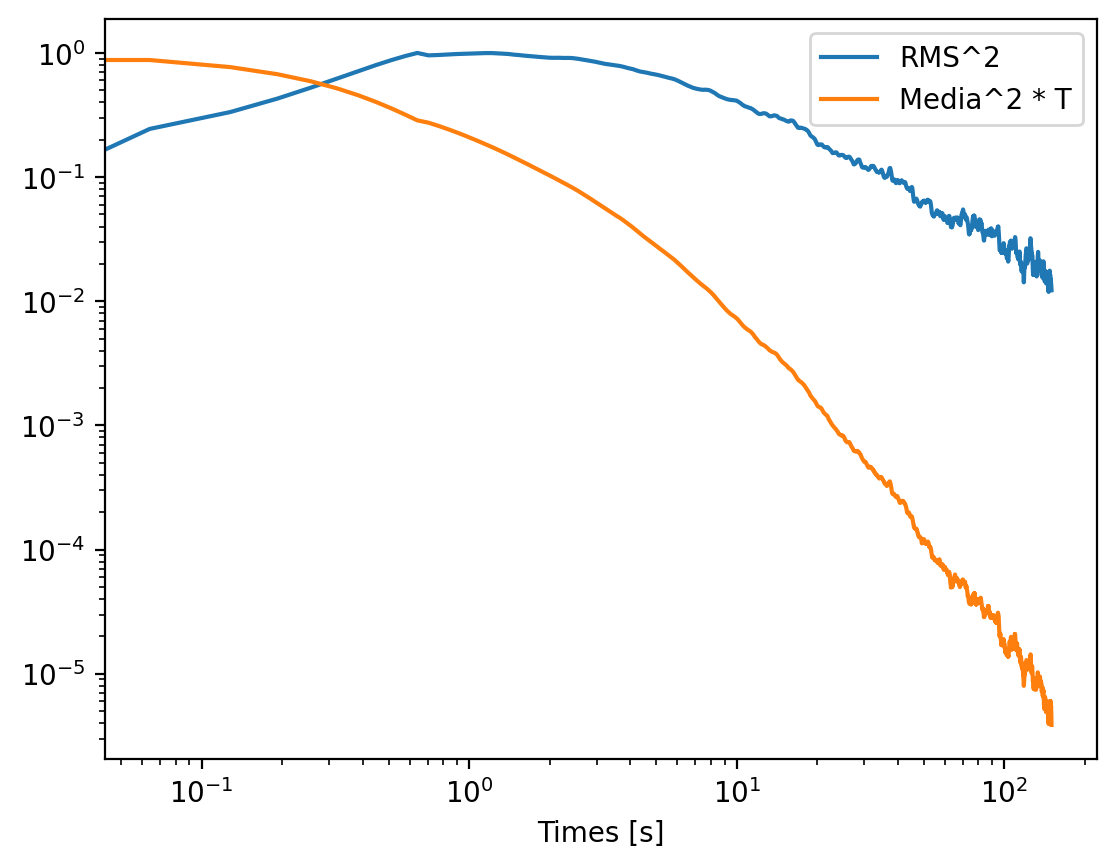

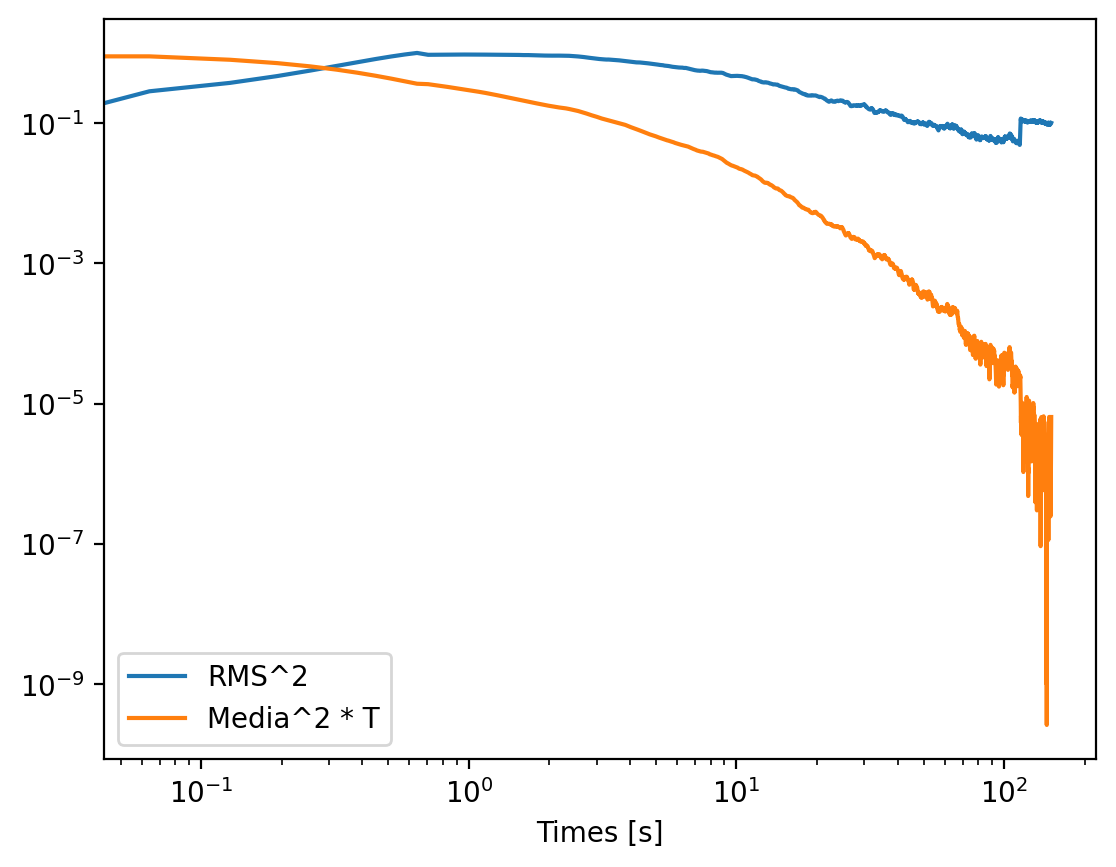

In [10]:
y1 = averaged_fluxes_rms_sim_batse**2
y2 = averaged_fluxes_sim_batse**2 * bin_time_batse
plt.plot(test_times_batse, y1/max(y1), label = 'RMS^2')
plt.plot(test_times_batse, y2/max(y2), label = 'Media^2 * T')
plt.xlabel('Times [s]')
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.figure()
y3 = averaged_fluxes_rms_batse**2
y4 = averaged_fluxes_batse**2 * bin_time_batse
plt.plot(test_times_batse, y3/max(y3), label = 'RMS^2')
plt.plot(test_times_batse, y4/max(y4), label = 'Media^2 * T')
plt.xlabel('Times [s]')
plt.legend()
plt.yscale('log')
plt.xscale('log')

### Swift

In [12]:
averaged_fluxes_swift, \
averaged_fluxes_cube_swift, \
averaged_fluxes_rms_swift, \
averaged_fluxes_cube_rms_swift = compute_average_quantities(grb_list=grb_list_swift, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_swift,
                                                            filter=True,
                                                            compute_rms=True)

averaged_fluxes_sim_swift, \
averaged_fluxes_cube_sim_swift, \
averaged_fluxes_rms_sim_swift, \
averaged_fluxes_cube_rms_sim_swift = compute_average_quantities(grb_list=grb_list_sim_swift, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_swift,
                                                                filter=True,
                                                                compute_rms=True)

### BeppoSAX

In [ ]:
averaged_fluxes_sax_hr, \
averaged_fluxes_cube_sax_hr, \
averaged_fluxes_rms_sax_hr = compute_average_quantities(grb_list=grb_list_sax_hr, 
                                                        t_f=t_f_sax, 
                                                        bin_time=bin_time_sax_hr,
                                                        filter=True, filter_window = 51)

averaged_fluxes_sim_sax_hr, \
averaged_fluxes_cube_sim_sax_hr, \
averaged_fluxes_rms_sim_sax_hr = compute_average_quantities(grb_list=grb_list_sim_sax_hr, 
                                                            t_f=t_f_sax, 
                                                            bin_time=bin_time_sax_hr,
                                                            filter=True, filter_window = 51)

In [ ]:
averaged_fluxes_sax_lr, \
averaged_fluxes_cube_sax_lr, \
averaged_fluxes_rms_sax_lr = compute_average_quantities(grb_list=grb_list_sax_lr, 
                                                        t_f=t_f, 
                                                        bin_time=bin_time_sax_lr,
                                                        filter=True, filter_window = 3)

averaged_fluxes_sim_sax_lr, \
averaged_fluxes_cube_sim_sax_lr, \
averaged_fluxes_rms_sim_sax_lr = compute_average_quantities(grb_list=grb_list_sim_sax_lr, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_sax_lr,
                                                            filter=True, filter_window = 3)

In [ ]:
#for grb in grb_list_sax_lr:
#    peak_pos = np.argmax(grb.counts)
#    if grb.counts[peak_pos + 25] < 0:
#        plt.figure()
#        plt.plot(grb.times, grb.counts)
#        plt.show()

### FERMI/GBM

In [13]:
averaged_fluxes_fermi, \
averaged_fluxes_cube_fermi, \
averaged_fluxes_rms_fermi, \
averaged_fluxes_cube_rms_fermi = compute_average_quantities(grb_list=grb_list_fermi, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_fermi,
                                                            filter=True, 
                                                            compute_rms=True)

averaged_fluxes_sim_fermi, \
averaged_fluxes_cube_sim_fermi, \
averaged_fluxes_rms_sim_fermi, \
averaged_fluxes_cube_rms_sim_fermi = compute_average_quantities(grb_list=grb_list_sim_fermi, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_fermi,
                                                                filter=True,
                                                                compute_rms=True)

# Test 3: Autocorrelation

- **`scipy.signal.correlation`**

    The correlation $z$ of two $d$-dimensional arrays $x$ and $y$ is defined as:

        z[...,k,...] = sum[..., i_l, ...] x[..., i_l,...] * conj(y[..., i_l - k,...])
        
    This way, if `x` and `y` are 1D arrays and ``z = correlate(x, y, 'full')``, then
    $$
          z[k] = (x * y)(k - N + 1)
               = \sum_{l=0}^{||x||-1}x_l y_{l-k+N-1}^{*}
    $$
    for $k = 0, 1, \dots, ||x|| + ||y|| - 2$, where $||x||$ is the length of $x$, $N = \max(||x||,||y||)$, and $y_m$ is $0$ when m is outside the range of $y$.


- **Link93**

    Following [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract), for a time lag $\tau$, the autocorrelation function is defined as

    $$
        A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
    $$
    where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
    $$
    \begin{aligned}
    & A(\tau)=1 & (\tau=0) \\
    & A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
    &
    \end{aligned}
    $$
    For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
    $$
    \begin{array}{rlr}
    A(\tau) &= 1 & (\tau=0) \\
    A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0)
    \end{array}
    $$
    where the lag is $\tau \equiv u \Delta t$.


### BATSE

In [11]:
# N_lim=np.min( [np.max(len(grb_list_sim_batse  )), 
#                np.max(len(grb_list_batse))] )
# #print(N_lim)
# assert len(grb_list_sim_batse) >= N_lim
# assert len(grb_list_batse)     >= N_lim

steps_sim_batse, \
acf_sim_batse, \
acf_rms_sim_batse = compute_autocorrelation(grb_list=grb_list_sim_batse,
                                            N_lim=len(grb_list_sim_batse),
                                            t_max=t_f,
                                            bin_time=bin_time_batse,
                                            mode='scipy',
                                            compute_rms=True)

steps_batse, \
acf_batse, \
acf_rms_batse = compute_autocorrelation(grb_list=grb_list_batse,
                                        N_lim=len(grb_list_batse),
                                        t_max=t_f,
                                        bin_time=bin_time_batse,
                                        mode='link93',
                                        compute_rms=True)  

### Swift

2343

In [ ]:
#print(bin_time_batse)
#np.isnan(acf_sim_batse)
# count the number of nan values    
#nan_values = np.isnan(acf_sim_batse)
#len(acf_sim_batse[nan_values])/len(acf_sim_batse)


0.064


In [15]:
# N_lim=np.min( [np.max(len(grb_list_sim_swift  )), 
#                np.max(len(grb_list_swift))] )
# #print(N_lim)
# assert len(grb_list_sim_swift) >= N_lim
# assert len(grb_list_swift)     >= N_lim

steps_sim_swift, \
acf_sim_swift, \
acf_rms_sim_swift = compute_autocorrelation(grb_list=grb_list_sim_swift,
                                            N_lim=len(grb_list_sim_swift),
                                            t_max=t_f,
                                            bin_time=bin_time_swift,
                                            mode='scipy',
                                            compute_rms=True)

steps_swift, \
acf_swift, \
acf_rms_swift     = compute_autocorrelation(grb_list=grb_list_swift,
                                            N_lim=len(grb_list_swift),
                                            t_max=t_f,
                                            bin_time=bin_time_swift,
                                            mode='link93',
                                            compute_rms=True)

### BeppoSAX

In [ ]:
# N_lim=np.min( [np.max(len(grb_list_sim_sax_hr)), 
#                np.max(len(grb_list_sax_hr))] )
# assert len(grb_list_sim_sax_hr) >= N_lim
# assert len(grb_list_sax_hr)     >= N_lim

# choose the method for computing the autocorrelation:
#mode='scipy'
#mode='link93'

steps_sim_sax_hr, acf_sim_sax_hr = compute_autocorrelation(grb_list=grb_list_sim_sax_hr,
                                                           N_lim=len(grb_list_sim_sax_hr),
                                                           t_max=t_f_sax,
                                                           bin_time=bin_time_sax_hr,
                                                           mode='scipy')

steps_sax_hr, acf_sax_hr         = compute_autocorrelation(grb_list=grb_list_sax_hr,
                                                           N_lim=len(grb_list_sax_hr),
                                                           t_max=t_f_sax,
                                                           bin_time=bin_time_sax_hr,
                                                           mode='link93')

In [ ]:
# N_lim=np.min( [np.max(len(grb_list_sim_sax_lr)), 
#                np.max(len(grb_list_sax_lr))] )
# assert len(grb_list_sim_sax_lr) >= N_lim
# assert len(grb_list_sax_lr)     >= N_lim

# choose the method for computing the autocorrelation:
#mode='scipy'
#mode='link93'

steps_sim_sax_lr, acf_sim_sax_lr = compute_autocorrelation(grb_list=grb_list_sim_sax_lr,
                                                           N_lim=len(grb_list_sim_sax_lr),
                                                           t_max=t_f,
                                                           bin_time=bin_time_sax_lr,
                                                           mode='scipy')

steps_sax_lr, acf_sax_lr         = compute_autocorrelation(grb_list=grb_list_sax_lr,
                                                           N_lim=len(grb_list_sax_lr),
                                                           t_max=t_f,
                                                           bin_time=bin_time_sax_lr,
                                                           mode='link93')

### FERMI/GBM

In [16]:
# N_lim=np.min( [np.max(len(grb_list_sim_fermi  )), 
#                np.max(len(grb_list_fermi))] )
# assert len(grb_list_sim_fermi) >= N_lim
# assert len(grb_list_fermi)     >= N_lim

steps_sim_fermi, \
acf_sim_fermi, \
acf_rms_sim_fermi = compute_autocorrelation(grb_list=grb_list_sim_fermi,
                                            N_lim=len(grb_list_sim_fermi),
                                            t_max=t_f,
                                            bin_time=bin_time_fermi,
                                            mode='scipy',
                                            compute_rms=True)

steps_fermi, \
acf_fermi, \
acf_rms_fermi = compute_autocorrelation(grb_list=grb_list_fermi,
                                        N_lim=len(grb_list_fermi),
                                        t_max=t_f,
                                        bin_time=bin_time_fermi,
                                        mode='link93',
                                        compute_rms=True)

# Test 4: Duration
Duration of the GRB measured at a level of 20% of the peak, as in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267). Before computing the duration, we filter the signal in order to smooth it.

### BATSE

In [12]:
#duration_batse       = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_batse)[0] for grb in grb_list_batse ]
#
#duration_sim_batse   = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_batse)[0] for grb in grb_list_sim_batse   ]

duration_batse     = [ grb.t20 for grb in grb_list_batse ]
duration_sim_batse = [ grb.t20 for grb in grb_list_sim_batse ]

dur_distr_batse     = compute_kde_log_duration(duration_batse)
dur_distr_sim_batse = compute_kde_log_duration(duration_sim_batse)

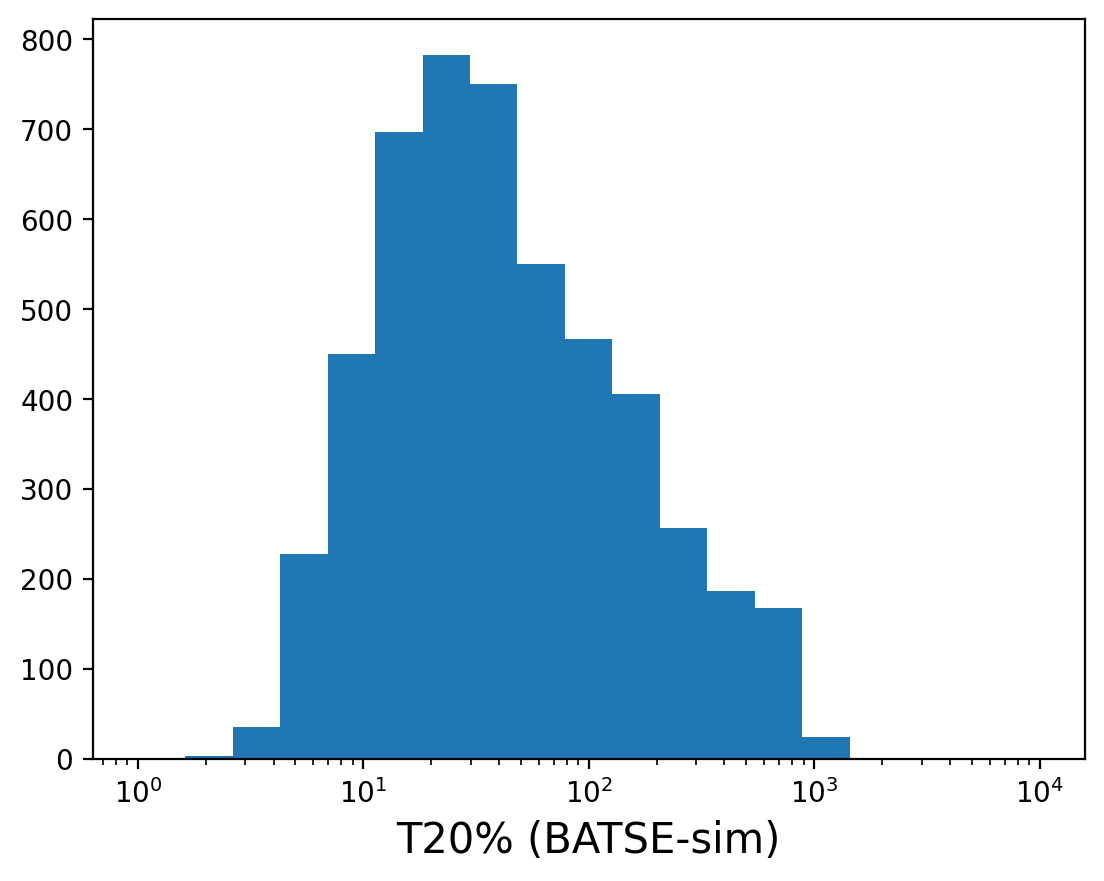

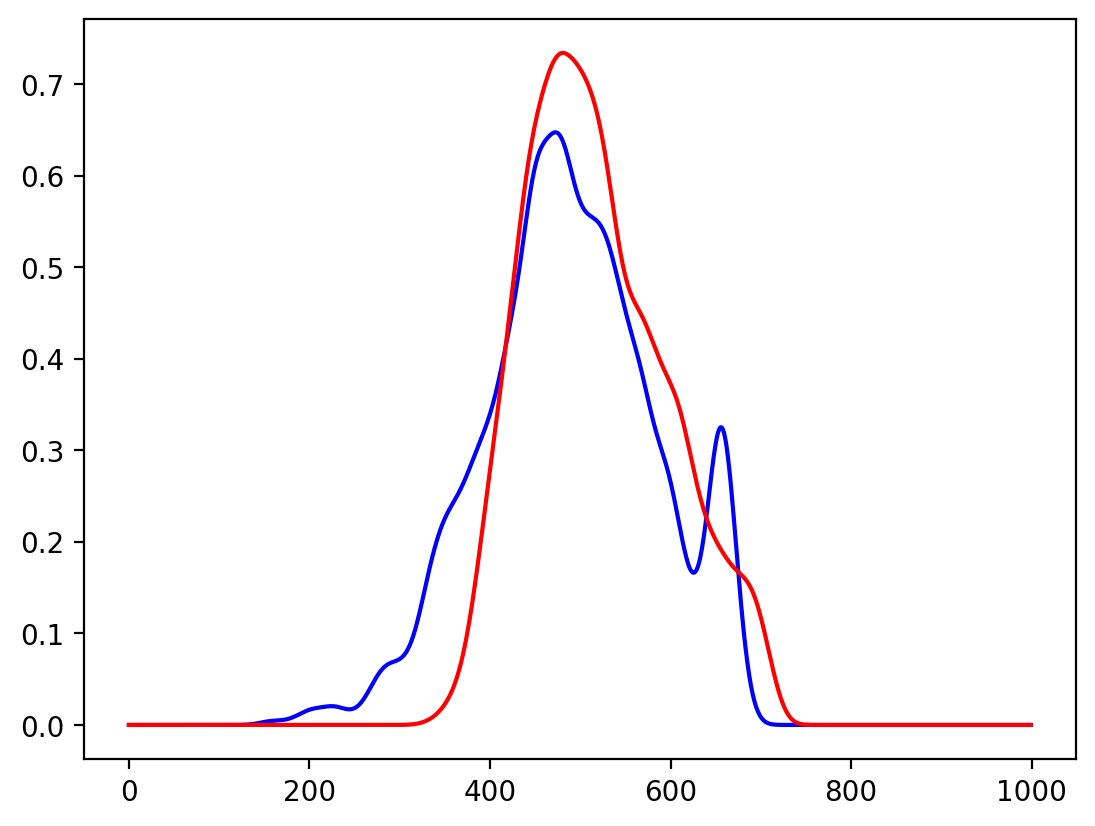

In [13]:
duration_sim_batse = [ grb.t20 for grb in grb_list_sim_batse ]

bins = np.logspace(0, 4, 20)
plt.hist(duration_sim_batse, bins=bins)
plt.xscale('log')
plt.xlabel('T20% (BATSE-sim)', size=15)
plt.show()

################################################################################

plt.plot(dur_distr_batse,     c='b')
plt.plot(dur_distr_sim_batse, c='r')
plt.show()

### Swift

In [19]:
#duration_swift       = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_swift)[0] for grb in grb_list_swift ]
#
#duration_sim_swift   = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_swift)[0] for grb in grb_list_sim_swift   ]

duration_swift     = [ grb.t20 for grb in grb_list_swift ]
duration_sim_swift = [ grb.t20 for grb in grb_list_sim_swift ]

dur_distr_swift     = compute_kde_log_duration(duration_swift)
dur_distr_sim_swift = compute_kde_log_duration(duration_sim_swift)

In [ ]:
duration_sim_swift = [ grb.t20 for grb in grb_list_sim_swift ]

bins = np.logspace(0, 4, 20)
plt.hist(duration_sim_swift, bins=bins)
plt.xscale('log')
plt.xlabel('T20% (Swift-sim)', size=15)
plt.show()

################################################################################

plt.plot(dur_distr_swift,     c='b')
plt.plot(dur_distr_sim_swift, c='r')
plt.show()

### BeppoSAX

In [ ]:
#duration_sax_hr       = [ evaluateDuration20(times=grb.times, 
#                                             counts=grb.counts,
#                                             filter=True,
#                                             t90=grb.t90,
#                                             t90_frac=15,
#                                             bin_time=bin_time_sax_hr)[0] for grb in grb_list_sax_hr ]
#
#duration_sim_sax_hr   = [ evaluateDuration20(times=grb.times, 
#                                             counts=grb.counts,
#                                             filter=True,
#                                             t90=grb.t90,
#                                             t90_frac=15,
#                                             bin_time=bin_time_sax_hr)[0] for grb in grb_list_sim_sax_hr   ]

duration_sax     = [ grb.t20 for grb in grb_list_sax ]
duration_sim_sax = [ grb.t20 for grb in grb_list_sim_sax ]

dur_distr_sax     = compute_kde_log_duration(duration_sax_hr)
dur_distr_sim_sax = compute_kde_log_duration(duration_sim_sax_hr)

In [ ]:
duration_sax_lr     = []
duration_sim_sax_lr = []

for grb in grb_list_sax_lr:
    try:
        duration_sax_lr.append(evaluateDuration20(times=grb.times, 
                                                  counts=grb.counts,
                                                  filter=False,
                                                  t90=grb.t90,
                                                  bin_time=bin_time_sax_lr)[0])
    except AssertionError:
        continue

for grb in grb_list_sim_sax_lr:
    try:
        duration_sim_sax_lr.append(evaluateDuration20(times=grb.times, 
                                                      counts=grb.counts,
                                                      filter=False,
                                                      t90=grb.t90,
                                                      bin_time=bin_time_sax_lr)[0])
    except AssertionError:
        continue


dur_distr_sax     = compute_kde_log_duration(duration_sax_lr)
dur_distr_sim_sax = compute_kde_log_duration(duration_sim_sax_lr)

### FERMI/GBM

In [21]:
duration_fermi     = [ grb.t20 for grb in grb_list_fermi ]
duration_sim_fermi = [ grb.t20 for grb in grb_list_sim_fermi ]

dur_distr_fermi     = compute_kde_log_duration(duration_fermi)
dur_distr_sim_fermi = compute_kde_log_duration(duration_sim_fermi)

In [ ]:
duration_sim_fermi = [ grb.t20 for grb in grb_list_sim_fermi]

bins = np.logspace(0, 4, 20)
plt.hist(duration_sim_fermi, bins=bins)
plt.xscale('log')
plt.xlabel('T20% (Fermi-sim)', size=15)
plt.show()

################################################################################

plt.plot(dur_distr_fermi,     c='b')
plt.plot(dur_distr_sim_fermi, c='r')
plt.show()

# Test 5: Number of significant peaks

From: **What the $p$-values really tell us - Francis Sahngun Nahm**

The $p$-value means the probability, for a given statistical model that, when the null hypothesis is true, the statistical summary would be equal to or more extreme than the actual observed results. Therefore, $p$-values only indicate how incompatible the data are with a specific statistical model (usually with a null-hypothesis $H_0$). The smaller the $p$-value, the greater statistical incompatibility of the data with the null hypothesis.

Can the $p$-value measure the probability that the study hypothesis (what the researches want to evaluate) is true? No. As defined in the definition of the $p$-value, it can only measure 'how the data are incompatible with a null-hypothesis', and cannot measure the compatibility of the data with a study hypothesis. The $p$-values only mean the probability of accepting the 'null hypothesis', and do not mean the probability of accepting the 'study hypothesis'. Even $p < 0.05$ cannot support the researchers’ arguments.

From: **Statistical Data Analysis - Cowan**

The $p$-value is the probability $p$, under assumption of the hypothesis in question $H_0$, of obtaining a result as compatible or less with $H_0$ than the one actually observed. The $p$-value is sometimes also called the observed significance level or confidence level of the test. That is, if we had specified a critical region for the test statistic with a significance level $\alpha$ equal to the $p$-value obtained, then the value of the statistic would be at the boundary of this region. The $p$-value is thus the fraction of times one would obtain data as compatible with $H_0$ or less so if the experiment (e.g., 20 coin tosses) were repeated many times under similar circumstances. 

### Comparing two dataset

The tests that compare distributions are _rule-out_ tests. They start with the null hypothesis that the 2 populations are identical, then try to reject that hypothesis. We can never prove the null to be true, just reject it, so these tests cannot really be used to show that 2 samples come from the same population (or identical populations).

When doing the statistical test of compatibility, we _do not_ check wether the two populations are compatible, rather we can only test if we can reject (with a certain confidence level $\alpha=5\%$) the possibility that they come from the same distribution (i.e., if the $p$-value is greater than e.g. $5\%$, then with the confidence level of $5\%$ we cannot discard the possibility that the two dataset come from the same distribution).  Conversely, we can reject the null hypothesis if the $p$-value is lower than that value. 

In other words, we cannot say if they come from the same distribution; we can only check if we can _reject_ the fact that they come from the same distribution. If $p>5\%$ then we cannot reject the null hypothesis $H_0$ that they come from the same underlying distribution, but that _does not_ mean that we have a confirmation that they come from the same distribution. 

If the $p$-value is very small (below $5\%$), we reject the null hypothesis and conclude that the two samples are not drawn from the same distribution (if we plot the two empirical cumulative distributions they should not overlap). Instead, if the $p$-value of the test is large (greater than the significance level, say $5\%$), we cannot reject the null hypothesis that they are drawn from the same distribution, and thus there should be a great deal of overlap between the empirical cumulative functions of these two dataset. Note that, not rejecting null hypothesis $H_0$ does _not_ mean we conclude that the two samples are drawn from the same distribution, it simply means we cannot reject the null given the two samples.

"Cannot reject doesn't mean we confirm."

### Chi-squared

From: **An introduction to error analysis - Taylor**

When testing the compatibility using the $\chi^2$, we begin by supposing that the two distribution are compatible, which is our $H_0$. With this assumption, we can calculate the probability of obtaining a value of $\chi^2$ as large as, or larger than, our obtained value, which is reminiscent of the definition of $p$-value. To do so, we compute the integral of the $\chi^2$ distribution up to the observed chi-squared value found, and we subtract this value to 1:
$$
p = \operatorname{Prob}\left({\chi}^2 \geqslant {\chi}_{\mathrm{o}}{ }^2\right) = \int^{\infty}_{{\chi}_{\mathrm{o}}^2} f_{\chi^2}(x, \mathrm{dof}) \,dx = 1 - \int_{0}^{{\chi}_{\mathrm{o}}^2} f_{\chi^2}(x, \mathrm{dof}) \, dx
$$
That is, if the two distribution are compatible, there would be an $p\,\%$ probability of obtaining a value of $\chi^2$ greater than or equal to our actual value ${\chi}_{\mathrm{o}}^2$. In other words, if this $p$-value obtained is larger than a certain threshold (e.g., $5\%$), then a value of $\chi^2$ as large as the one observed is not at all unreasonable, so we would have no reason (based on this evidence) to reject our null hypothesis that the two dataset come from the same distribution.

Our general procedure should now be reasonably clear. After completing any series of measurements, we calculate the chi squared, which we now denote by ${\chi}_{\mathrm{o}}^2$ (where the subscript o stands for "observed"). Next, assuming our measurements do follow the expected distribution, we compute the probability
$$
\operatorname{Prob}\left({\chi}^2 \geqslant {\chi}_{\mathrm{o}}{ }^2\right)
$$
of finding a value of ${\chi}^2$ greater than or equal to the observed value ${\chi}_{\mathrm{o}}^2$. If this probability is high, our value ${\chi}_{\mathrm{o}}{ }^2$ is perfectly acceptable, and we have no reason to reject our expected distribution. If this probability is unreasonably low, a value of ${\chi}^2$ as large as our observed ${\chi}_{\mathrm{o}}{ }^2$ is very unlikely (if our measurements were distributed as expected), and our expected distribution is correspondingly unlikely to be correct.

As always with statistical tests, we have to decide on the boundary between what is reasonably probable and what is not. With the boundary at 5\%, we would say that our observed value ${\chi}_{\mathrm{o}}^2$ indicates a significant _disagreement_ if
$$
\operatorname{Prob}\left({\chi}^2 \geqslant {\chi}_{\mathrm{o}}^2\right)<5 \%,
$$
and we would reject our expected distribution at the $5 \%$ significance level.

## Test 5a: Number of significative peaks (MEPSA _real_ vs MEPSA _sim_)

#### Run MEPSA on the _simulated_ light-curves for BATSE (very slow!)

In [ ]:
#reb_factor     = 32
#peak_sn_level  = 5
#n_of_peaks_sim = [runMEPSA(mepsa_path=mepsa_path, 
#                           ex_pattern_file_path=ex_pattern_path, 
#                           grb_file_path=grb.data_file_path, 
#                           nbins=reb_factor, 
#                           grb_name=grb.name, 
#                           sn_level=peak_sn_level) for grb in tqdm(grb_list_sim_batse)]
#mepsa_pulses = n_of_peaks_sim
#mepsa_sim    = n_of_peaks_sim


# MEPSA:     90 min = 5400 s
# OUR-CODE: (598 - 361) s = 237 s

If already computed, read the result of MEPSA (on the _simulations_) from the folder in which they are stored

In [ ]:
version = '14'

if user=='AF':
    mepsa_out_path = 'E:/grb_to_test/MEPSA results/AAAAAAAAAAAAAAA'
elif user=='LB':
    mepsa_out_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/'+version+'/'

mepsa_out_file_list = [ mepsa_out_path + file for file in os.listdir(mepsa_out_path)]
n_of_peaks_sim      = readMEPSAres(mepsa_out_file_list, 32, 5)
mepsa_sim           = n_of_peaks_sim

#### Read the MEPSA outputs for the _real_ BATSE data already evaluated by CG

In [ ]:
if user=='AF':
    path='E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
elif user=='LB':
    path='/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'

reb_factor               = np.inf
peak_sn_level            = 5
mepsa_out_file_list_temp = open('./grb_for_mepsa_BATSE.txt', 'r').readlines()
mepsa_out_file_list_temp = [ el.rstrip('\n') for el in mepsa_out_file_list_temp ] 
mepsa_out_file_list      = [ path+'peaks_'+el+'_all_bs_2.txt' for el in mepsa_out_file_list_temp ]
with open('./mepsa_BATSE.txt', 'w') as output:
    for el in mepsa_out_file_list:
        output.write(el + '\n')
n_of_peaks_batse         = readMEPSAres(mepsa_out_file_list=mepsa_out_file_list, 
                                        maximum_reb_factor=reb_factor, 
                                        sn_level=peak_sn_level)
n_of_pulses = n_of_peaks_batse 
mepsa_batse = n_of_pulses

#### Read the MEPSA outputs for the _real_ Swift data already evaluated by CG

In [ ]:
if user=='AF':
    path='E:/grb_to_test/Swift_BAT/PEAKS_ALL/NEU2/'
elif user=='LB':
    path='/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/PEAKS_ALL/NEU2/'

reb_factor               = np.inf
peak_sn_level            = 5
mepsa_out_file_list_temp = open('./grb_for_mepsa_Swift.txt', 'r').readlines()
mepsa_out_file_list_temp = [ el.rstrip('\n') for el in mepsa_out_file_list_temp ] 
mepsa_out_file_list      = [ path+'peaks_'+el+'_all_neu2.txt' for el in mepsa_out_file_list_temp ]
with open('./mepsa_Swift.txt', 'w') as output:
    for el in mepsa_out_file_list:
        output.write(el + '\n')
n_of_peaks_batse         = readMEPSAres(mepsa_out_file_list=mepsa_out_file_list, 
                                        maximum_reb_factor=reb_factor, 
                                        sn_level=peak_sn_level)
n_of_pulses = n_of_peaks_batse 
mepsa_batse = n_of_pulses

In [16]:
mepsa_out_file_list_temp = open('./grb_for_mepsa_Swift.txt', 'r').readlines()
mepsa_out_file_list_temp = [ el.rstrip('\n') for el in mepsa_out_file_list_temp ] 
mepsa_out_file_list      = [ 'peaks_'+el+'_all_neu2.txt' for el in mepsa_out_file_list_temp ]
with open('./mepsa_Swift.txt', 'w') as output:
    for el in mepsa_out_file_list:
        output.write(el + '\n')

#### Plot: MEPSA on BATSE vs MEPSA on simulated lc

In [ ]:
n_bins = 20
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

ax.hist(mepsa_sim, 
        bins=n_bins, 
        label='Simulated', 
        alpha=1.00,
        color='r',
        histtype='step',
        linewidth=4,
        density=True)

ax.hist(mepsa_batse, 
        bins=n_bins,
        alpha=0.75,
        label='BATSE', 
        color='b',
        histtype='step',
        linewidth=4,
        density=True)

ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.legend()
ax.set_ylabel('Density of GRBs')
ax.set_xlabel('Number of significative peaks')
plt.show()

## Test 5b: Number of significative peaks (MEPSA _real_ vs Peak count method)

In [ ]:
version    = '14'

#------------------------------------------------------------------------------#
# OUR CODE
#------------------------------------------------------------------------------#
if user=='AF':
    gen_file = open('D:/Lavoro_uni/grb_to_test/simulations/batse/extra/gen14/n_of_pulses.txt', 'r')
elif user=='LB':
    gen_file = open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/additional/v'+version+'/n_of_pulses.txt', 'r')
good_pulses = []
#generated_pulses = []
for line in gen_file:
    good_pulses.append(float(line.split()[0]))
    #generated_pulses.append(float(line.split()[2]))
n_of_pulses_sim = good_pulses
mepsa_like_sim  = n_of_pulses_sim 

#------------------------------------------------------------------------------#
# MEPSA (simulati)
#------------------------------------------------------------------------------#
#grb_name = range(2000)
grb_name = range(1000)
mepsa_pulses = []
for grb in grb_name:
    if user=='AF':
        mepsa_pulses.append(len(open('D:/Lavoro_uni/grb_to_test/MEPSA results/gen14/{0}.dat'.format(grb),'r').readlines()) -1 )
    elif user=='LB':
        mepsa_pulses.append(len(open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/'+version+'/{0}.dat'.format(grb),'r').readlines()) -1 )
mepsa_sim = mepsa_pulses 

#------------------------------------------------------------------------------#

In [10]:
from scipy.stats import anderson_ksamp, ks_2samp

def perform_KS_AD(distr_1, distr_2):
    res_ad = anderson_ksamp([distr_1,distr_2] )
    res_ks = ks_2samp(distr_1,distr_2)
    print('AD (p-value): ', res_ad.significance_level)
    print('KS (p-value): ', res_ks.pvalue)
    return [res_ad.significance_level, res_ks.pvalue] 

In [ ]:
nbins     = 20
mepsamin  = np.min(mepsa_batse)
mepsamax  = np.max(mepsa_batse)
bin_edges = np.linspace(mepsamin, mepsamax, nbins+1)

#------------------------------------------------------------------------------#

new_bins, new_counts = rebin_histogram(bin_edges=bin_edges,
                                       data=mepsa_batse,
                                       n_min=20)

#------------------------------------------------------------------------------#

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot()
ax.bar(x=new_bins[:-1], height=new_counts, width=np.diff(new_bins), align='edge', fc='skyblue', ec='black', label=r'Rebinned ($n_i\geq20$)', alpha=0.9) # label='MEPSA (BATSE) REBINNED'
n_mepsa, _, _ = ax.hist(mepsa_batse, bins=nbins, label=r'$\texttt{n_bins=20}$',  color='b', histtype='step', linewidth=3, density=False, alpha=0.99)    # label='MEPSA (BATSE)'
#ax.set_yscale('log')
ax.set_xlabel('Number of pulses', size=18)
ax.set_ylabel('Number of GRBs',   size=18)
ax.set_xticks(new_bins)
ax.grid(which='both')
ax.legend()
plt.title('MEPSA (BATSE)', size=22)
plt.show()

#------------------------------------------------------------------------------#

print('##################################################')
print('### OLD')
print('##################################################')
print('\n')
print('nbins =', nbins)
print('\n')
print('len(bin_edges) =', len(bin_edges))
print('bin_edges =', bin_edges)
print('\n')
print('len(n_mepsa) =', len(n_mepsa))
print('n_mepsa =', n_mepsa)
print('\n')
print('##################################################')
print('### NEW (rebinned)')
print('##################################################')
print('\n')
print('new_bins  = ', new_bins)
print('new_edges = ', new_counts)
print('\n')
print('##################################################')

In [ ]:
# NOT REBINNED

nbins = 20

#------------------------------------------------------------------------------#
# MEPSA (BATSE) vs Peak count method (v14)
#------------------------------------------------------------------------------#
print('MEPSA (BATSE) vs Peak count method (SIMv14):')

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot()
n_mepsa, bins, patches = ax.hist(mepsa_batse,    bins=nbins, label='MEPSA (BATSE)',  color='b', histtype='step', linewidth=2.5, density=True, alpha=0.7)
n_good,     _,       _ = ax.hist(mepsa_like_sim, bins=bins,  label='Our code (sim)', color='r', histtype='step', linewidth=2.,  density=True)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.grid(which='both')
ax.set_xlabel('Number of pulses', size=18)
ax.set_ylabel('GRBs density', size=18)
ax.legend()
plt.title('MEPSA (BATSE) vs Peak count method (SIMv14)', size=22)
plt.show()

#------------------------------------------------------------------------------#
# MEPSA (v8) vs Peak count method (v14)
#------------------------------------------------------------------------------#

print('\nMEPSA (SIMv8) vs Peak count method (SIMv14):')

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot()
n_mepsa, bins, patches = ax.hist(mepsa_sim,      bins=nbins, label='MEPSA (sim)',    color='b', histtype='step', linewidth=2.5, density=True, alpha=0.7)
n_good,     _,       _ = ax.hist(mepsa_like_sim, bins=bins,  label='Our code (sim)', color='r', histtype='step', linewidth=2.,  density=True)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.grid(which='both')
ax.set_xlabel('Number of pulses', size=18)
ax.set_ylabel('GRBs density', size=18)
ax.legend()
plt.title('MEPSA (SIMv8) vs Peak count method (SIMv14)', size=22)
plt.show()

#_ = perform_KS_AD(mepsa_sim, mepsa_like_sim)

#------------------------------------------------------------------------------#

In [ ]:
nbins     = 40
mepsamin  = np.min(mepsa_sim)
mepsamax  = np.max(mepsa_sim)
bin_edges = np.linspace(mepsamin, mepsamax, nbins+1)
#bin_edges = np.linspace(0, mepsamax, nbins+1)

#------------------------------------------------------------------------------#

new_bins, new_counts = rebin_histogram(bin_edges=bin_edges,
                                       data=mepsa_sim,
                                       n_min=20)
num_bins = len(new_bins)-1
mepsa_counts_sim = new_counts
mepsa_bins_sim   = new_bins

#------------------------------------------------------------------------------#

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot()
new_bins[-1] = np.max( [np.max(mepsa_like_sim), np.max(mepsa_sim)] )
ax.bar(x=new_bins[:-1], height=new_counts, width=np.diff(new_bins), align='edge', fc='skyblue', ec='black', label=r'MEPSA (sim) - Rebinned', alpha=0.9) 
mepsa_like_counts_sim, _, _ = ax.hist(mepsa_like_sim, bins=new_bins, label=r'MEPSA-like (sim) - Rebinned',  color='b', histtype='step', linewidth=3, density=False, alpha=0.99) 
#ax.set_yscale('log')
ax.set_xlabel('Number of pulses', size=18)
ax.set_ylabel('Number of GRBs',   size=18)
ax.set_xticks(new_bins)
ax.grid(which='both')
ax.legend()
plt.title('MEPSA (SIMv8) vs Peak count method (SIMv14) _REBINNED_', size=22)
plt.show()

In [ ]:
f              = np.sum(mepsa_like_counts_sim) / np.sum(mepsa_counts_sim)
chisquared     = np.sum( (mepsa_like_counts_sim - f*mepsa_counts_sim)**2 / (f**2*mepsa_counts_sim))
red_chisquared = chisquared/(num_bins-1)
print('chi2     =', chisquared)
print('chi2/dof =', red_chisquared)

from scipy.stats import chi2
pvalue = 1 - chi2.cdf(chisquared,   # chi square (NOT the reduced one)
                      (num_bins-1)) # degrees of freedom
print('p-value  =', pvalue)

from scipy.stats import chisquare
chisquare(mepsa_like_counts_sim, f_exp=f*mepsa_counts_sim)

In [ ]:
np.shape(np.where(np.array(mepsa_like_sim)<1))

In [ ]:
print(np.sum(counts_like))
print(np.sum(new_counts))

In [ ]:
print(len(mepsa_like_sim))
print(len(mepsa_sim))

# Test 6: S/N distribution


### BATSE

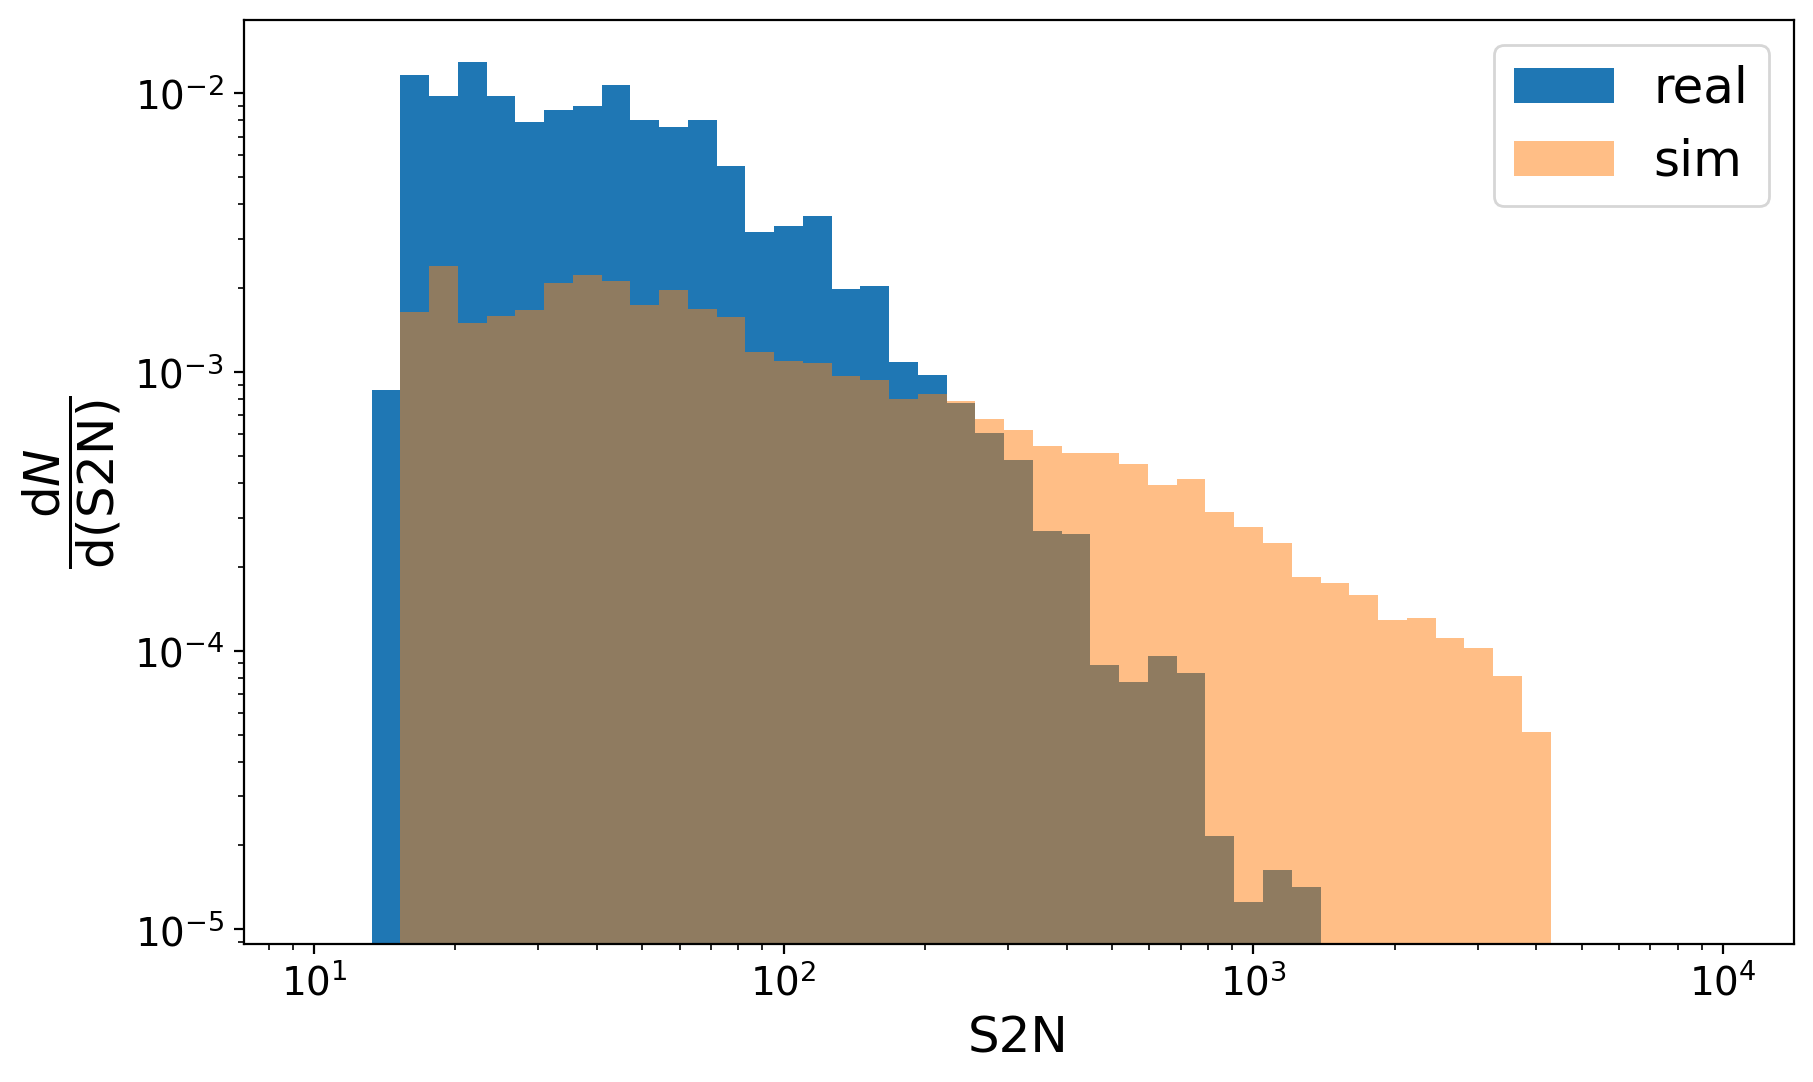

In [14]:
batse_real_SNlist = np.array([evaluateGRB_SN(grb.times, grb.counts, grb.errs, grb.t90, t90_frac, bin_time_batse, filter=True)[0] for grb in grb_list_batse])
batse_sim_SNlist  = np.array([evaluateGRB_SN(grb.times, grb.counts, grb.errs, grb.t90, t90_frac, bin_time_batse, filter=True)[0] for grb in grb_list_sim_batse])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bins = np.logspace(1, 4, 50)
n, bins, patches = ax.hist(batse_real_SNlist, bins=bins, alpha=1.0, density=True, label='real')
_,    _,      _, = ax.hist(batse_sim_SNlist,  bins=bins, alpha=0.5, density=True, label='sim') 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel(r'S2N', size=18)
ax.set_ylabel(r'$\dfrac{\mathrm{d}N}{\mathrm{d(S2N)}}$', size=18)
ax.legend(fontsize=18)
ax.loglog()
# ax.grid()
plt.show()

In [15]:
np.max(batse_real_SNlist)*1

1385.5025634765625

In [16]:
print('AD p-value: ', two_pop_test(batse_real_SNlist, batse_sim_SNlist, mode='AD'))
print('KS p-value: ', two_pop_test(batse_real_SNlist, batse_sim_SNlist, mode='KS'))

AD p-value:  0.001
KS p-value:  3.355e-321


/astrodata/romain/sde_GA/geneticgrbs_v2/lc_pulse_avalanche/statistical_test.py:1246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  res_ad = anderson_ksamp([distr_1,distr_2])


4999 5000


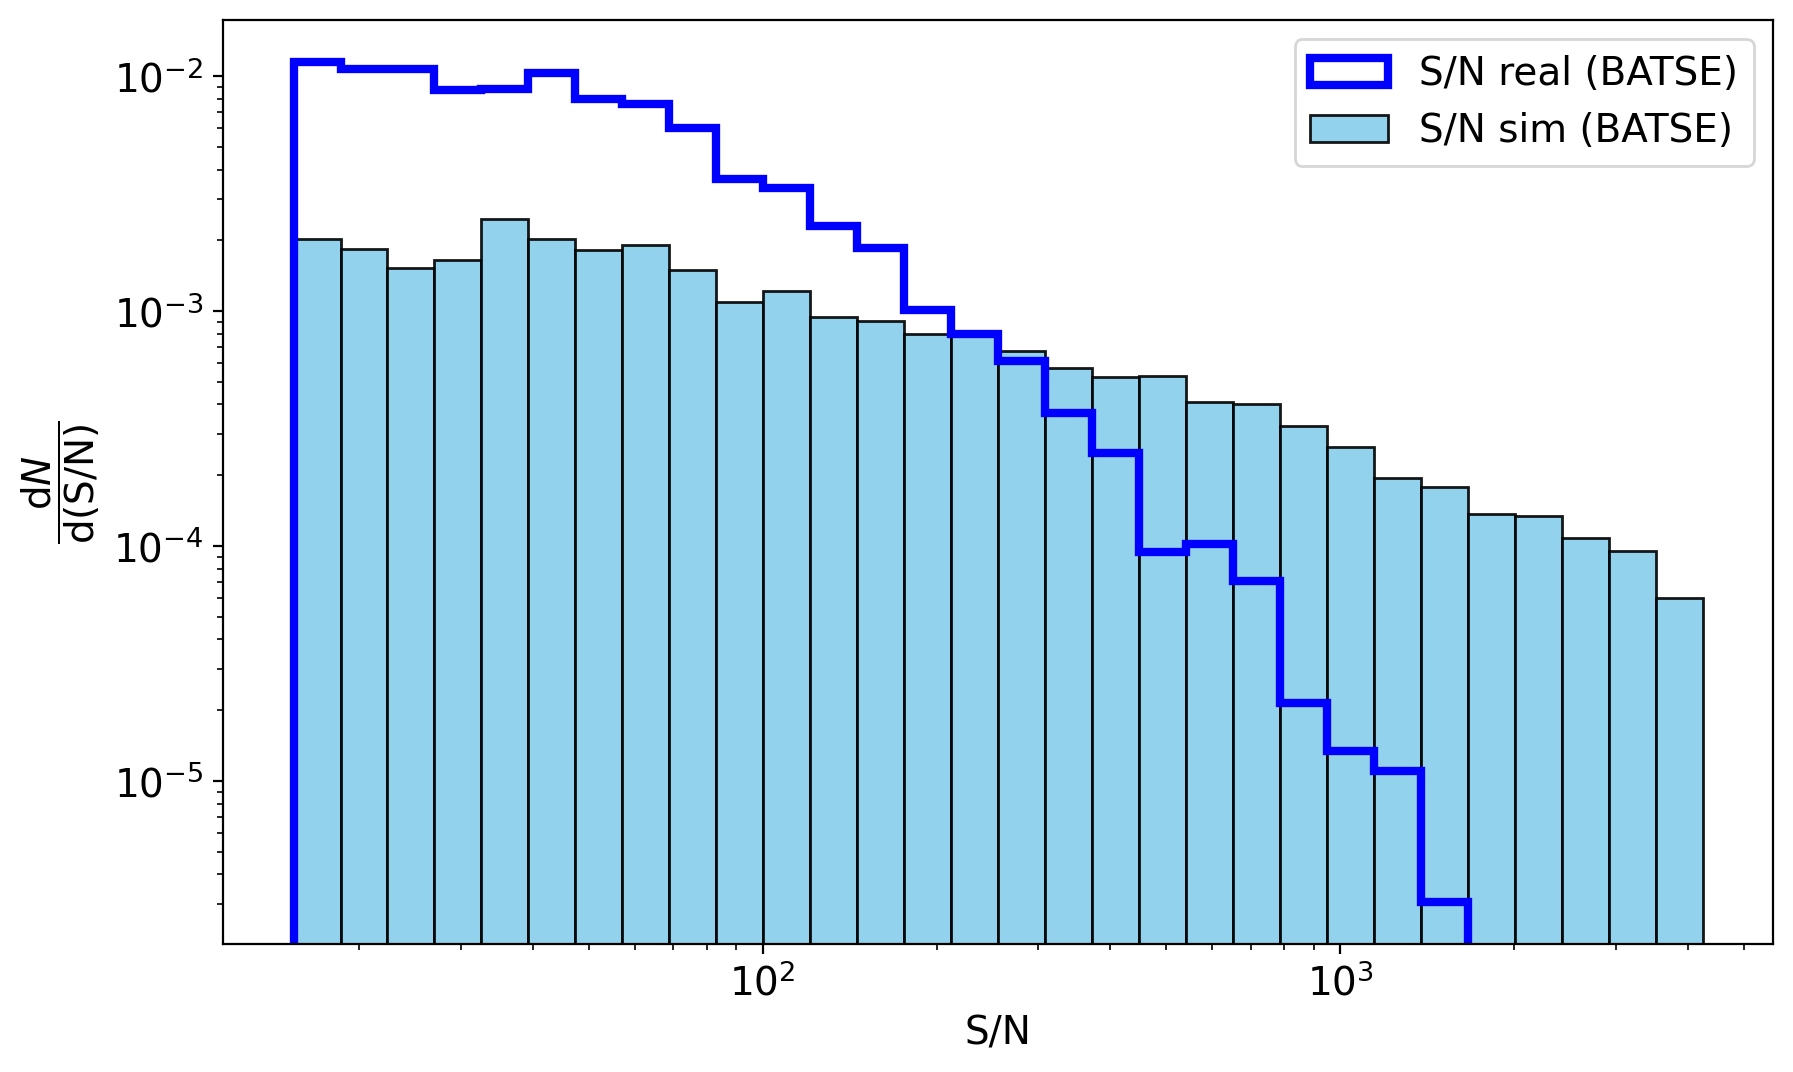

In [17]:
#from statistical_test import *

def rebin_histogram(bin_edges, data, n_min=20):
    """
    Rebins the histogram so that each bin contains at least 20 data points.
    We start with a predefined set of bins (e.g., we decide the have nbins=15
    bins, so that bin_edges will be: 
        bin_edges = np.linspace(min(data), max(data), nbins+1)
    Every time in a predefined bin there are less than n_min=20 counts, we 
    extend the right endpoint of the current bin towards the next bin. We do
    this iteratively until the current (enlarged) bin has >= n_min=20 points.
    The last points on the right that do not form a complete bin of n_min is
    included in the bin immediately before (which then becomes the last one).
    Args:
        - bin_edges: A list of the bin endpoints;
        - data: The data to be rebinned;
    Returns:
        - new_bin_edges: A list of the new bin edges;
        - new_bin_counts: A list of the new bin counts;
    """
  
    data      = np.array(data)
    bin_edges = np.array(bin_edges)
    new_bin_counts = []
    new_bin_edges  = []
    new_bin_edges.append(bin_edges[0])
    for i in range(len(bin_edges)-1):
        bin_count = len( data[(new_bin_edges[-1]<=data) & (data<bin_edges[i+1])] )
        if (bin_count >= n_min):
            new_bin_edges.append(bin_edges[i+1])
            new_bin_counts.append(bin_count)

    if (np.sum(new_bin_counts)!=len(data)):
        # if the last data did not form a bin with len>20, 
        # then we incorporate in the last complete (n>20) bin
        new_bin_counts[-1] += len(data[data>=new_bin_edges[-1]])
        new_bin_edges[-1]   = bin_edges[-1]
    new_bin_counts = np.array(new_bin_counts).astype('int')
    print(np.sum(new_bin_counts),len(data))
    #assert np.sum(new_bin_counts) == len(data), "The number of counts in the rebinned histogram is different from the initial one!" 
    
    return new_bin_edges, new_bin_counts
nbins     = 30
binmin    = np.min(batse_sim_SNlist)
binmax    = np.max(batse_sim_SNlist)
bin_edges = np.logspace(np.log10(binmin), np.log10(binmax), nbins+1)
#bin_edges= np.linspace(0, mepsamax, nbins+1)

#------------------------------------------------------------------------------#

new_bins, new_counts = rebin_histogram(bin_edges=bin_edges,
                                       data=batse_sim_SNlist,
                                       n_min=20)
num_bins      = len(new_bins)-1
sn_counts_sim = new_counts
sn_bins_sim   = new_bins
bin_sizes     = np.diff(new_bins)

#------------------------------------------------------------------------------#

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
new_bins[-1] = np.max([np.max(batse_sim_SNlist), np.max(batse_real_SNlist)])
################################################################################
# Bar plot
################################################################################
x_bar      = new_bins[:-1]
height_bar = new_counts/(sum(new_counts)*np.diff(new_bins)) # Prob. density
width_bar  = np.diff(new_bins)
ax.bar(x=x_bar, height=height_bar, width=width_bar, align='edge', alpha=0.9, 
       ec='black', fc='skyblue', label=r'S/N sim (BATSE)')
################################################################################
# Hist
################################################################################
sn_real_counts_sim, _, _ = ax.hist(batse_real_SNlist, bins=new_bins, color='b', 
                                   density=True, histtype='step', linewidth=3,
                                   label=r'S/N real (BATSE)',) 
################################################################################
ax.set_xlabel(r'S/N', size=14)
ax.set_ylabel(r'$\dfrac{\mathrm{d}N}{\mathrm{d(S/N)}}$', size=14)
ax.set_xticks(new_bins[::3])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
# ax.grid(which='both')
ax.loglog()
ax.legend(fontsize=14)
plt.savefig('./s2n_distr_batse.pdf', format='pdf')
plt.show()

### Swift

In [ ]:
swift_real_SNlist = np.array([evaluateGRB_SN(grb.times, grb.counts, grb.errs, grb.t90, t90_frac, bin_time_swift, filter=True)[0] for grb in grb_list_swift])
swift_sim_SNlist  = np.array([evaluateGRB_SN(grb.times, grb.counts, grb.errs, grb.t90, t90_frac, bin_time_swift, filter=True)[0] for grb in grb_list_sim_swift])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bins = np.logspace(1, 4, 50)
n, bins, patches = plt.hist(swift_real_SNlist, bins=bins, alpha=1.0, density=True, label='real')
_,    _,      _, = plt.hist(swift_sim_SNlist,  bins=bins, alpha=0.5, density=True, label='sim') 
ax.legend(fontsize=18)
ax.loglog()
ax.grid()
plt.show()

In [18]:
print('AD p-value: ', two_pop_test(swift_real_SNlist, swift_sim_SNlist, mode='AD'))
print('KS p-value: ', two_pop_test(swift_real_SNlist, swift_sim_SNlist, mode='KS'))

NameError: name 'swift_real_SNlist' is not defined

In [ ]:
nbins     = 40
binmin    = np.min(swift_sim_SNlist)
binmax    = np.max(swift_sim_SNlist)
bin_edges = np.logspace(np.log10(binmin), np.log10(binmax), nbins+1)
#bin_edges= np.linspace(0, mepsamax, nbins+1)

#------------------------------------------------------------------------------#

new_bins, new_counts = rebin_histogram(bin_edges=bin_edges,
                                       data=swift_sim_SNlist,
                                       n_min=20)
num_bins      = len(new_bins)-1
sn_counts_sim = new_counts
sn_bins_sim   = new_bins
bin_sizes     = np.diff(new_bins)

#------------------------------------------------------------------------------#

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
new_bins[-1] = np.max([np.max(swift_sim_SNlist), np.max(swift_real_SNlist)])
################################################################################
# Bar plot
################################################################################
x_bar      = new_bins[:-1]
height_bar = new_counts/(sum(new_counts)*np.diff(new_bins)) # Prob. density
width_bar  = np.diff(new_bins)
ax.bar(x=x_bar, height=height_bar, width=width_bar, align='edge', alpha=0.9, 
       ec='black', fc='skyblue', label=r'S/N sim (Swift)')
# ax.bar(x=new_bins[:-1], height=new_counts/sum(new_counts)/np.diff(new_bins), width=np.diff(new_bins), align='edge', fc='skyblue', ec='black', label=r'S/N sim (BATSE)', alpha=0.9) 
################################################################################
# Hist
################################################################################
sn_real_counts_sim, _, _ = ax.hist(swift_real_SNlist, bins=new_bins, color='b',
                                   density=True, histtype='step', linewidth=3,
                                   label=r'S/N real (Swift)') 
################################################################################
ax.set_xlabel('S/N', size=18)
ax.set_ylabel('Prob. density', size=18)
ax.set_xticks(new_bins[::3])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
# ax.grid(which='both')
ax.loglog()
ax.legend(fontsize=14)
plt.savefig('./s2n_distr')
plt.show()

### FERMI/GBM

In [ ]:
fermi_real_SNlist = np.array([evaluateGRB_SN(grb.times, grb.counts, grb.errs, grb.t90, t90_frac, bin_time_fermi, filter=True)[0] for grb in grb_list_fermi])
fermi_sim_SNlist  = np.array([evaluateGRB_SN(grb.times, grb.counts, grb.errs, grb.t90, t90_frac, bin_time_fermi, filter=True)[0] for grb in grb_list_sim_fermi])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bins = np.logspace(1, 4, 50)
n, bins, patches = ax.hist(fermi_real_SNlist, bins=bins, alpha=1.0, density=True, label='real')
_,    _,      _, = ax.hist(fermi_sim_SNlist,  bins=bins, alpha=0.5, density=True, label='sim') 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel(r'S2N', size=18)
ax.set_ylabel(r'$\dfrac{\mathrm{d}N}{\mathrm{d(S2N)}}$', size=18)
ax.legend(fontsize=18)
ax.loglog()
# ax.grid()
plt.show()

In [ ]:
print('AD p-value: ', two_pop_test(fermi_real_SNlist, fermi_sim_SNlist, mode='AD'))
print('KS p-value: ', two_pop_test(fermi_real_SNlist, fermi_sim_SNlist, mode='KS'))

In [ ]:
nbins     = 40
binmin    = np.min(fermi_sim_SNlist)
binmax    = np.max(fermi_sim_SNlist)
bin_edges = np.logspace(np.log10(binmin), np.log10(binmax), nbins+1)
#bin_edges= np.linspace(0, mepsamax, nbins+1)

#------------------------------------------------------------------------------#
new_bins, new_counts = rebin_histogram(bin_edges=bin_edges,
                                       data=fermi_sim_SNlist,
                                       n_min=20)
num_bins      = len(new_bins)-1
sn_counts_sim = new_counts
sn_bins_sim   = new_bins
bin_sizes     = np.diff(new_bins)

#------------------------------------------------------------------------------#

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
new_bins[-1] = np.max([np.max(fermi_sim_SNlist), np.max(fermi_real_SNlist)])
################################################################################
# Bar plot
################################################################################
x_bar      = new_bins[:-1]
height_bar = new_counts/(sum(new_counts)*np.diff(new_bins)) # Prob. density
width_bar  = np.diff(new_bins)
ax.bar(x=x_bar, height=height_bar, width=width_bar, align='edge', alpha=0.9, 
       ec='black', fc='skyblue', label=r'S/N sim (Fermi)')
################################################################################
# Hist
################################################################################
sn_real_counts_sim, _, _ = ax.hist(fermi_real_SNlist, bins=new_bins, color='b', 
                                   density=True, histtype='step', linewidth=3,
                                   label=r'S/N real (Fermi)',) 
################################################################################
ax.set_xlabel(r'S2N', size=18)
ax.set_ylabel(r'$\dfrac{\mathrm{d}N}{\mathrm{d(S2N)}}$', size=18)
ax.set_xticks(new_bins[::3])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
# ax.grid(which='both')
ax.loglog()
ax.legend(fontsize=14)
plt.savefig('./s2n_distr_fermi')
plt.show()

In [ ]:
# Generate x values in log space
x = np.logspace(-10, 0, 10000)
# Compute corresponding y values
y = np.array([loss_compatibility_test(xi) for xi in x])
# Plot the points
plt.figure(figsize=(8, 6))
plt.plot(x, y, color='k', label='Loss function')
plt.axvline(1e-9,  color='r', linestyle='--', label=r'$p=10^{-9}$')
plt.axvline(0.05,  color='g', linestyle='--', label=r'$p=0.05$')
plt.axvline(1,     color='b', linestyle='--', label=r'$p=1$')
plt.xlabel(r'$p$-value', size=14)
plt.ylabel(r'Loss', rotation=90, size=14)
plt.title('Loss S/N distribution', size=16)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# 6. LOSS

### BATSE

In [19]:
#test_pulse_distr = True
test_pulse_distr = False
if ~test_pulse_distr:
    mepsa_batse=None
    mepsa_like_sim=None

l2_loss_batse, l2_loss_fluxes_batse, l2_loss_fluxes_cube_batse, l2_loss_acf_batse, l2_loss_duration_batse, l_sn_distr_batse = \
    compute_loss(averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
                 averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
                 acf=acf_batse,                                   acf_sim=acf_sim_batse,
                 duration=dur_distr_batse,                        duration_sim=dur_distr_sim_batse, 
                 n_of_pulses=mepsa_batse,                         n_of_pulses_sim=mepsa_like_sim,   
                 sn_distrib_real=batse_real_SNlist,               sn_distrib_sim=batse_sim_SNlist, 
                 test_sn_distr=True,  
                 return_individual_loss=True,
                 test_pulse_distr=test_pulse_distr)

# if test_pulse_distr:
#     nbin=20
#     # Perform the AD 2-populations compatibility test between:
#     # - la distribuzione del numero di impulsi calcolata da MEPSA (su dati BATSE)
#     # - la distribuzione del numero di impulsi calcolato con il nostro codice (sulla simulazione corrente)
#     n_mepsa_real, bins = np.histogram(n_of_pulses,     bins=nbin, density=True)
#     n_peaks_sim,     _ = np.histogram(n_of_pulses_sim, bins=nbin, density=True)
#     p_AD               = AD_2pop_test(distr_1=n_mepsa_real,
#                                       distr_2=n_peaks_sim)
#     l_AD               = loss_AD(p_AD=p_AD)
#     print('p-value of the AD-test: ', p_AD)

print('Total loss for BATSE:', l2_loss_batse)
print('a. loss <F/F_P>     for BATSE:', l2_loss_fluxes_batse)
print('b. loss <(F/F_P)^3> for BATSE:', l2_loss_fluxes_cube_batse)
print('c. loss <ACF>       for BATSE:', l2_loss_acf_batse)
print('d. loss T_20%-distr for BATSE:', l2_loss_duration_batse)
print('e. loss S/N-distr   for BATSE:', l_sn_distr_batse)

Total loss for BATSE: 2.8813372610176153
a. loss <F/F_P>     for BATSE: 1.0533956336157007
b. loss <(F/F_P)^3> for BATSE: 0.6381689801527429
c. loss <ACF>       for BATSE: 0.4875387953194244
d. loss T_20%-distr for BATSE: 2.227582896000208
e. loss S/N-distr   for BATSE: 10.0


### Swift

In [ ]:
#test_pulse_distr = True
test_pulse_distr = False
if ~test_pulse_distr:
    mepsa_swift=None
    mepsa_like_sim=None

l2_loss_swift, l2_loss_fluxes_swift, l2_loss_fluxes_cube_swift, l2_loss_acf_swift, l2_loss_duration_swift, l_sn_distr_swift = \
    compute_loss(averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
                 averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
                 acf=acf_swift,                                   acf_sim=acf_sim_swift,
                 duration=dur_distr_swift,                        duration_sim=dur_distr_sim_swift, 
                 n_of_pulses=mepsa_swift,                         n_of_pulses_sim=mepsa_like_sim,   
                 sn_distrib_real=swift_real_SNlist,               sn_distrib_sim=swift_sim_SNlist, 
                 test_sn_distr=True,  
                 return_individual_loss=True,
                 test_pulse_distr=test_pulse_distr)

print('Total loss for Swift:', l2_loss_swift)
print('a. loss <F/F_P>     for Swift:', l2_loss_fluxes_swift)
print('b. loss <(F/F_P)^3> for Swift:', l2_loss_fluxes_cube_swift)
print('c. loss <ACF>       for Swift:', l2_loss_acf_swift)
print('d. loss T_20%-distr for Swift:', l2_loss_duration_swift)
print('e. loss S/N-distr   for Swift:', l_sn_distr_swift)

### BeppoSAX

In [ ]:
test_pulse_distr = False
l2_loss_sax = compute_loss(averaged_fluxes=averaged_fluxes_sax,           averaged_fluxes_sim=averaged_fluxes_sim_sax,
                           averaged_fluxes_cube=averaged_fluxes_cube_sax, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax,
                           acf=acf_sax,                                   acf_sim=acf_sim_sax,
                           duration=dur_distr_sax,                        duration_sim=dur_distr_sim_sax, 
                           n_of_pulses=None,                              n_of_pulses_sim=None,   
                           test_pulse_distr=test_pulse_distr)

print('Total loss for BeppoSAX:', l2_loss_sax)

### FERMI/GBM

In [ ]:
#test_pulse_distr = True
test_pulse_distr = False
if ~test_pulse_distr:
    mepsa_fermi=None
    mepsa_like_sim=None

l2_loss_fermi, \
l2_loss_fluxes_fermi, \
l2_loss_fluxes_cube_fermi, \
l2_loss_acf_fermi, \
l2_loss_duration_fermi, \
l_sn_distr_fermi = compute_loss(averaged_fluxes=averaged_fluxes_fermi,           
                                averaged_fluxes_sim=averaged_fluxes_sim_fermi,
                                averaged_fluxes_cube=averaged_fluxes_cube_fermi, 
                                averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_fermi,
                                acf=acf_fermi,                                   
                                acf_sim=acf_sim_fermi,
                                duration=dur_distr_fermi,                        
                                duration_sim=dur_distr_sim_fermi, 
                                n_of_pulses=mepsa_fermi,                         
                                n_of_pulses_sim=mepsa_like_sim,   
                                sn_distrib_real=fermi_real_SNlist,               
                                sn_distrib_sim=fermi_sim_SNlist, 
                                test_sn_distr=True,  
                                return_individual_loss=True,
                                test_pulse_distr=test_pulse_distr)

print('Total loss for Fermi:', l2_loss_fermi)
print('a. loss <F/F_P>     for Fermi:', l2_loss_fluxes_fermi)
print('b. loss <(F/F_P)^3> for Fermi:', l2_loss_fluxes_cube_fermi)
print('c. loss <ACF>       for Fermi:', l2_loss_acf_fermi)
print('d. loss T_20%-distr for Fermi:', l2_loss_duration_fermi)
print('e. loss S/N-distr   for Fermi:', l_sn_distr_fermi)

# 7. PLOTS

- $p$-value for KS test on the duration times distribution: #TODO
- $p$-value for AD test on the duration times distribution: #TODO

## BATSE

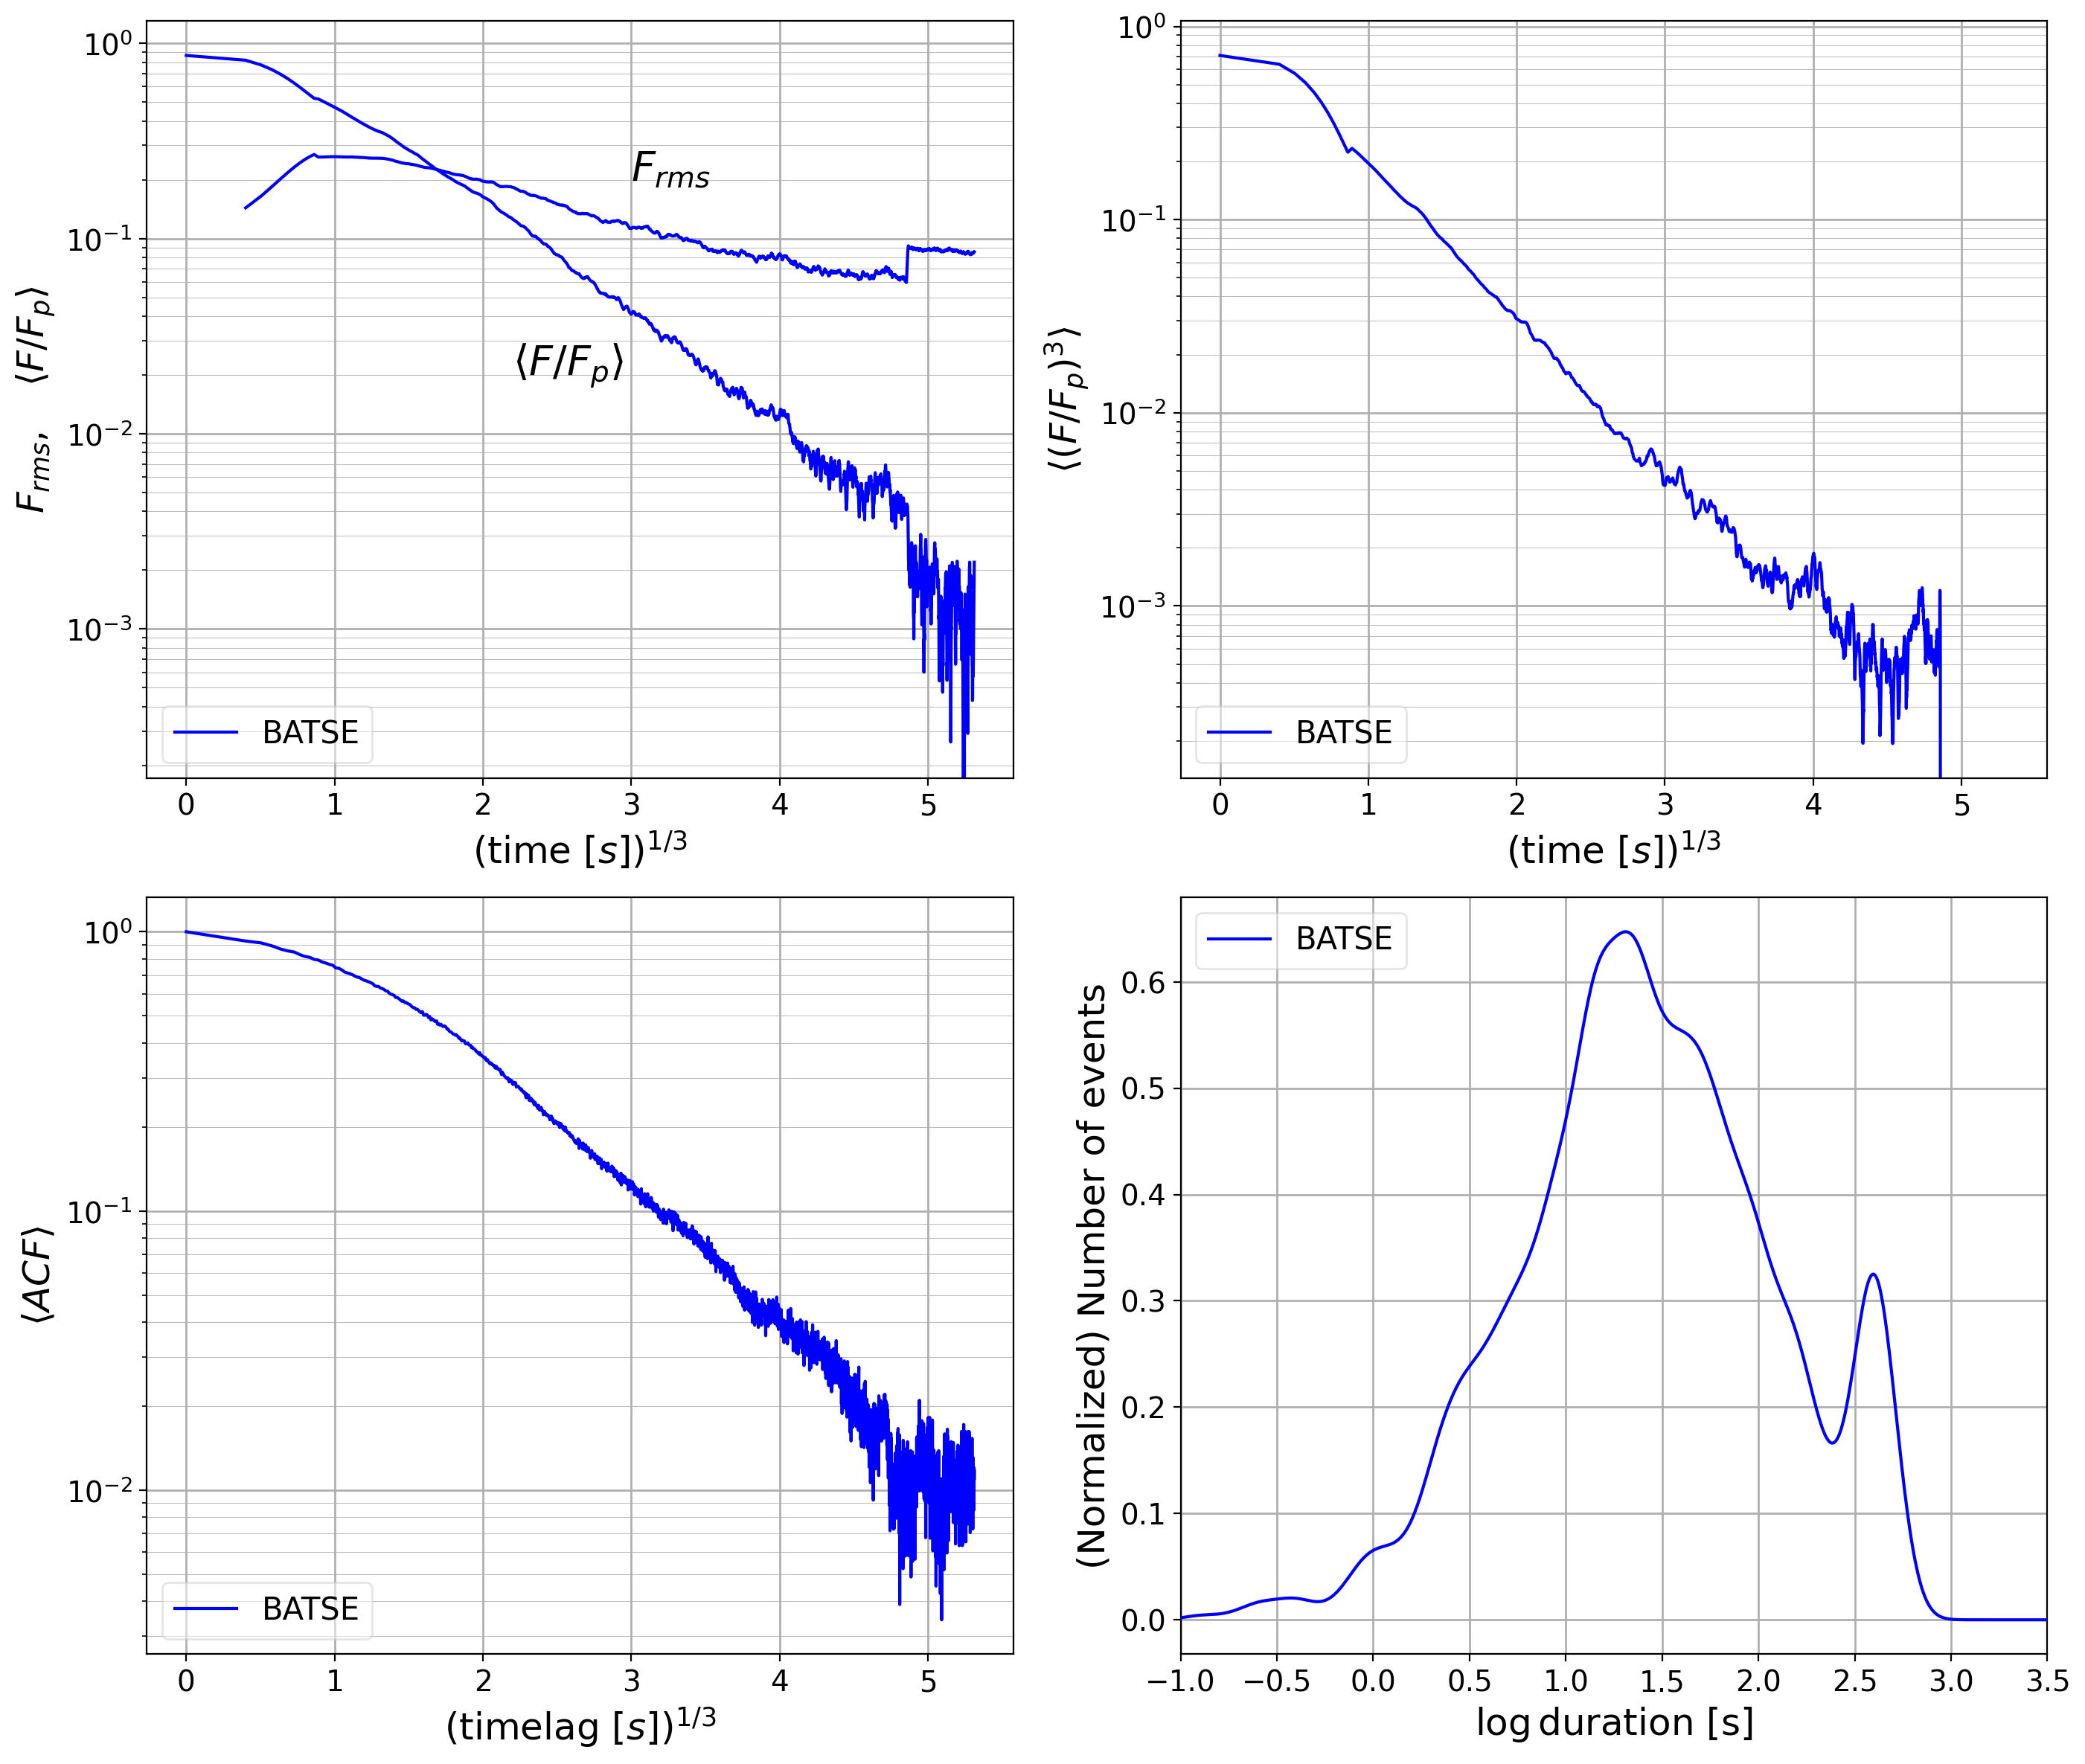

In [20]:
# BATSE ONLY
make_plot_one(instrument='batse',
              test_times=test_times_batse, 
              averaged_fluxes=averaged_fluxes_batse,          
              averaged_fluxes_rms=averaged_fluxes_rms_batse,  
              averaged_fluxes_cube=averaged_fluxes_cube_batse,
              steps=steps_batse, bin_time=bin_time_batse, 
              acf=acf_batse,                                  
              duration=duration_batse,                        
              # mode
              log=True, hist=False, 
              # error bars
              err_bars=False, sigma=1,
              n_grb_real=len(grb_list_batse),                          
              averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, 
              acf_rms=acf_rms_batse,                 
              save_fig=False)

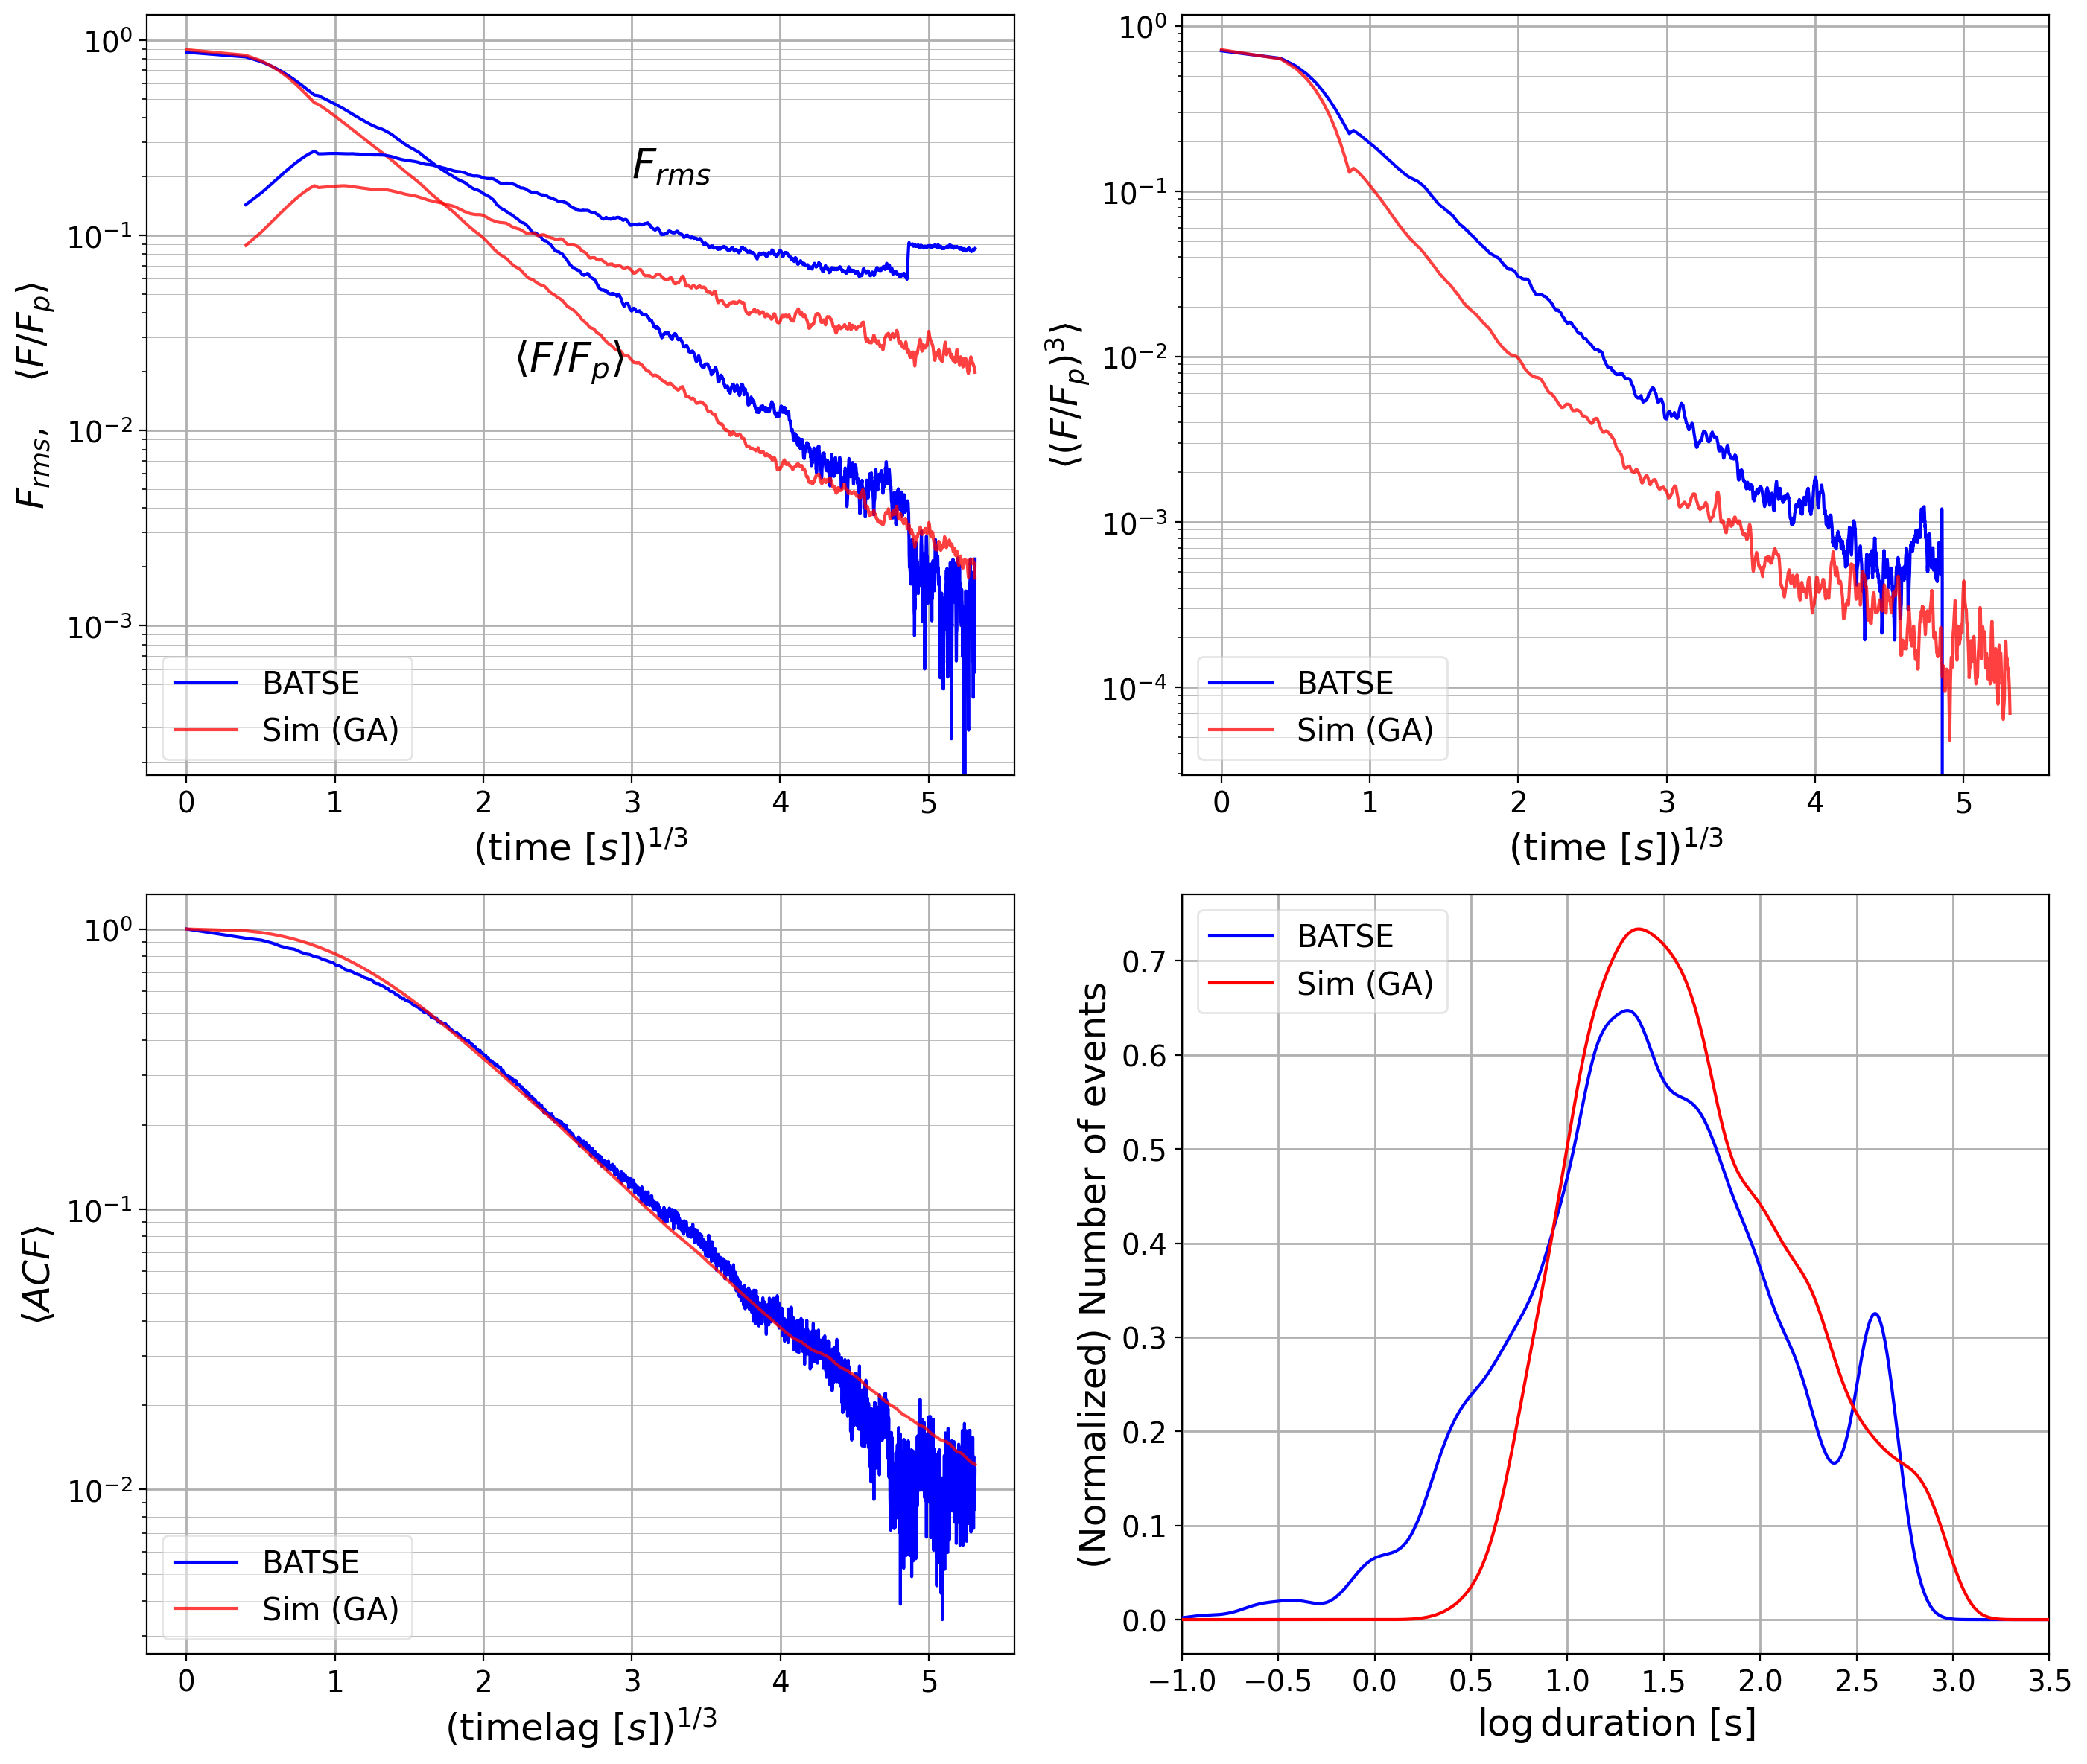

In [21]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse,    bin_time=bin_time_batse, 
          acf=acf_batse,                                   acf_sim=acf_sim_batse,
          duration=duration_batse,                         duration_sim=duration_sim_batse,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=False, sigma=1,
          n_grb_real=len(grb_list_batse),                          n_grb_sim=len(grb_list_sim_batse),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
          acf_rms=acf_rms_batse,                                   acf_rms_sim=acf_rms_sim_batse,
          save_fig=True, name_fig='metrics2.png')

In [22]:
def make_plot_5metrics(instrument, 
                       test_times, 
                       # plot 1
                       averaged_fluxes,      
                       averaged_fluxes_sim,
                       averaged_fluxes_rms,  
                       averaged_fluxes_rms_sim,
                       # plot 2
                       averaged_fluxes_cube, 
                       averaged_fluxes_cube_sim,
                       # plot 3
                       steps, 
                       steps_sim, 
                       bin_time, 
                       acf, 
                       acf_sim,
                       # plot 4
                       duration, 
                       duration_sim,
                       #plot 5
                       sn_real,
                       sn_sim,
                       # mode
                       log=True, 
                       hist=False, 
                       # error bars
                       err_bars=False, 
                       sigma=1,
                       averaged_fluxes_cube_rms=None, 
                       averaged_fluxes_cube_rms_sim=None,
                       acf_rms=None,                  
                       acf_rms_sim=None,
                       n_grb_real=None,               
                       n_grb_sim=None, 
                       # save plot
                       save_fig=False, 
                       name_fig='fig.pdf'):
    """
    Make plot as in Stern et al., 1996.
    """

    fig = plt.figure(figsize=(20, 12), dpi=300)
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

    if instrument=='batse':
        label_instr='BATSE'
        label_sim='Sim (GA)'
        #n_grb_real=578
    elif instrument=='swift':
        label_instr='Swift'
        label_sim='Sim (GA)'
        #n_grb_real=531
    elif instrument=='sax':
        label_instr='BeppoSAX'
        label_sim='Sim (GA)'
        #n_grb_real=121 # #TODO: check this number
    elif instrument=='fermi':
        label_instr='Fermi'
        label_sim='Sim (GA)'
        #n_grb_real=245 # #TODO: check this number
    else:
        raise NameError('Variable "instrument" not defined properly; choose between: "batse", "swift", "sax", "fermi".')

    averaged_fluxes          = np.array(averaged_fluxes)
    averaged_fluxes_sim      = np.array(averaged_fluxes_sim)
    averaged_fluxes_rms      = np.array(averaged_fluxes_rms)
    averaged_fluxes_rms_sim  = np.array(averaged_fluxes_rms_sim)
    averaged_fluxes_cube     = np.array(averaged_fluxes_cube)
    averaged_fluxes_cube_sim = np.array(averaged_fluxes_cube_sim)
    acf                      = np.array(acf)
    acf_sim                  = np.array(acf_sim)
    duration                 = np.array(duration)
    duration_sim             = np.array(duration_sim)
    s2n_distr                = np.array(sn_real)
    s2n_distr_sim            = np.array(sn_sim)

    #--------------------------------------------------------------------------#
    # <(F/F_p)>
    #--------------------------------------------------------------------------#

    # plots
    ax1.plot(test_times**(1/3),     averaged_fluxes,                color='b', lw=1.5, alpha=1.00, label=label_instr)
    ax1.plot(test_times**(1/3),     averaged_fluxes_sim,            color='r', lw=1.5, alpha=0.75, label=label_sim)
    ax1.plot(test_times[1:]**(1/3), averaged_fluxes_rms[1:],        color='b', lw=1.5, alpha=1.00)
    ax1.plot(test_times[1:]**(1/3), averaged_fluxes_rms_sim[1:],    color='r', lw=1.5, alpha=0.75)
    # error bars
    if err_bars:
        errs     = averaged_fluxes_rms     / np.sqrt(n_grb_real)
        errs_sim = averaged_fluxes_rms_sim / np.sqrt(n_grb_sim)
        #
        ax1.fill_between(test_times**(1/3),
                         averaged_fluxes-sigma*errs,
                         averaged_fluxes+sigma*errs,
                         color='b',
                         alpha=0.2) 
        ax1.fill_between(test_times**(1/3),
                         averaged_fluxes_sim-sigma*errs_sim,
                         averaged_fluxes_sim+sigma*errs_sim,
                         color='r',
                         alpha=0.2)
    # set scale
    if log:
        ax1.set_yscale('log', base=10) 
        #ax[0,0].set_xlim(0,test_times[-1]**(1/3))
        if err_bars:
            ax1.set_ylim(1.e-3, 1.2)
    else:
        pass
        #ax[0,0].set_xlim(0,test_times[-1]**(1/3))
    # set labels
    ax1.set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=18)
    if log:
        ax1.set_ylabel(r'$F_{rms},\quad \langle F/F_p\rangle$', size=18)
        #ax[0,0].set_ylabel(r'$\log F_{rms},\quad \log \langle F/F_p\rangle$', size=18)
    else:
        ax1.set_ylabel(r'$F_{rms},\quad \langle F/F_p\rangle$', size=18)
    #
    ax1.text(3,   10**(-0.7), r'$F_{rms}$',              fontsize=20)
    ax1.text(2.2, 10**(-1.7), r'$\langle F/F_p\rangle$', fontsize=20)
    #
    ax1.grid(True, which="major", lw=1.0, ls="-")
    ax1.grid(True, which="minor", lw=0.3, ls="-")
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

    #--------------------------------------------------------------------------#
    # <(F/F_p)^3>
    #--------------------------------------------------------------------------#

    # plots
    ax2.plot(test_times**(1/3), averaged_fluxes_cube,     color='b', lw=1.5, label=label_instr)
    ax2.plot(test_times**(1/3), averaged_fluxes_cube_sim, color='r', lw=1.5, label=label_sim, alpha=0.75)
    # error bars
    if err_bars:
        errs     = averaged_fluxes_cube_rms     / np.sqrt(n_grb_real)
        errs_sim = averaged_fluxes_cube_rms_sim / np.sqrt(n_grb_sim)
        #
        ax2.fill_between(test_times**(1/3),
                         averaged_fluxes_cube-sigma*errs,
                         averaged_fluxes_cube+sigma*errs,
                         color='b',
                         alpha=0.2) 
        ax2.fill_between(test_times**(1/3),
                         averaged_fluxes_cube_sim-sigma*errs_sim,
                         averaged_fluxes_cube_sim+sigma*errs_sim,
                         color='r',
                         alpha=0.2)

    # set scale
    if log:
        ax2.set_yscale('log', base=10)
        #ax[0,1].set_xlim(0,test_times[-1]**(1/3))
        if err_bars:
            ax2.set_ylim(7.e-5, 1)
    else:
        pass
        #ax[0,1].set_xlim(0,test_times[-1]**(1/3))
    # set labels
    ax2.set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=18)
    if log:
        ax2.set_ylabel(r'$\langle (F/F_p)^3 \rangle$', size=18)
        #ax[0,1].set_ylabel(r'$\log \langle (F/F_p)^3 \rangle$', size=18)
    else:
        ax2.set_ylabel(r'$\langle (F/F_p)^3 \rangle$', size=18)
    #
    ax2.grid(True, which="major", lw=1.0, ls="-")
    ax2.grid(True, which="minor", lw=0.3, ls="-")
    ax2.xaxis.set_tick_params(labelsize=14)
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

    #--------------------------------------------------------------------------#
    # AUTOCORRELATION
    #--------------------------------------------------------------------------#

    # plots
    ax3.plot((steps    *bin_time)**(1/3), acf,     color='b', lw=1.5, label=label_instr)
    ax3.plot((steps_sim*bin_time)**(1/3), acf_sim, color='r', lw=1.5, label=label_sim, alpha=0.75)
    # error bars
    if err_bars:
        errs     = acf_rms     / np.sqrt(n_grb_real)
        errs_sim = acf_rms_sim / np.sqrt(n_grb_sim)
        #
        ax3.fill_between((steps*bin_time)**(1/3),
                         acf-sigma*errs,
                         acf+sigma*errs,
                         color='b',
                         alpha=0.2) 
        ax3.fill_between((steps_sim*bin_time)**(1/3),
                         acf_sim-sigma*errs_sim,
                         acf_sim+sigma*errs_sim,
                         color='r',
                         alpha=0.2)
    # set scale
    if log:
        ax3.set_yscale('log', base=10)
    else:
        pass
    # set labels
    ax3.set_xlabel(r'$(\mathrm{timelag}\ [s])^{1/3}$', size=18)
    if log:
        ax3.set_ylabel(r'$\langle ACF \rangle$', size=18)
        #ax[1,0].set_ylabel(r'$\log \langle ACF \rangle$', size=18)
    else:
        ax3.set_ylabel(r'$\langle ACF \rangle$', size=18)
    #
    ax3.grid(True, which="major", lw=1.0, ls="-")
    ax3.grid(True, which="minor", lw=0.3, ls="-")
    ax3.xaxis.set_tick_params(labelsize=14)
    ax3.yaxis.set_tick_params(labelsize=14)
    ax3.legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

    #--------------------------------------------------------------------------#
    # DISTRIBUTION OF DURATIONS
    #--------------------------------------------------------------------------#

    if log:
        duration     = np.log10(duration)
        duration_sim = np.log10(duration_sim)
    if log:
        range_hist = [-1.0, 3.5]
    else:
        range_hist = None

    if hist:
        # histogram
        n_bins=30
        n1, bins = np.histogram(a=duration,     bins=n_bins, range=range_hist)
        n2, bins = np.histogram(a=duration_sim, bins=n_bins, range=range_hist)

        bin_centres = 0.5 * (bins[:-1] + bins[1:])

        ax4.bar(x=bins[:-1], 
                    height=n1/(np.diff(bins)[0]*len(duration)),     
                    width=np.diff(bins), 
                    align='edge',
                    #facecolor='None',
                    #edgecolor='b',
                    #linewidth=2,
                    alpha=0.6,
                    color='b',
                    label=label_instr)
        ax4.bar(x=bins[:-1], 
                    height=n2/(np.diff(bins)[0]*len(duration_sim)), 
                    width=np.diff(bins), 
                    align='edge',
                    #facecolor='None',
                    edgecolor='r',
                    linewidth=2,
                    alpha=0.4,
                    color='r',
                    label='Simulated')

        ax4.set_ylim(-0.025,1.0)

        if err_bars:
            # Plot the error bars, centred on (bin_centre, bin_count), with length y_error
            ax4.errorbar(x=bin_centres, 
                             y=n1/(np.diff(bins)[0]*len(duration)),
                             yerr=sigma*np.sqrt(n1)/(np.diff(bins)[0]*len(duration)), 
                             fmt='.', 
                             color='b',
                             capsize=3,
                             elinewidth=1.5)
            ax4.errorbar(x=bin_centres, 
                             y=n2/(np.diff(bins)[0]*len(duration_sim)),
                             yerr=sigma*np.sqrt(n2)/(np.diff(bins)[0]*len(duration_sim)), 
                             fmt='.', 
                             color='r',
                             capsize=3,
                             elinewidth=1.5)


    else: 
        # kernel density estimation
        h_opt = 0.09 # values obtained with GridSearch optimization (see the notebook in DEBUG section)
        if log:
            x_grid = np.linspace(-2,    5, 1000)
        else:
            x_grid = np.linspace(-2, 1000, 1000)
        y_plot_real  = stats.norm.pdf(x_grid, duration[:, None],     h_opt)
        y_plot_sim   = stats.norm.pdf(x_grid, duration_sim[:, None], h_opt)
        y_plot_real /= (len(duration))
        y_plot_sim  /= (len(duration_sim))
        kde_real     = y_plot_real.sum(0)
        kde_sim      = y_plot_sim.sum(0)
        # plot
        ax4.plot(x_grid, kde_real, c='b', lw=1.5, label=label_instr, zorder=5)
        ax4.plot(x_grid, kde_sim,  c='r', lw=1.5, label=label_sim,   zorder=6)
        # errors
        if err_bars:
            n_resample=500
            kde_real_r_stack     = np.zeros([len(kde_real),n_resample])
            kde_real_r_stack_sim = np.zeros([len(kde_sim), n_resample])
            for i in range(n_resample):
                dur_resampled_real = resample(duration,     replace=True)
                dur_resampled_sim  = resample(duration_sim, replace=True)
                y_plot_real_r      = stats.norm.pdf(x_grid, dur_resampled_real[:, None], h_opt)
                y_plot_sim_r       = stats.norm.pdf(x_grid, dur_resampled_sim[:, None],  h_opt)
                y_plot_real_r     /= (len(dur_resampled_real))
                y_plot_sim_r      /= (len(dur_resampled_sim))
                kde_real_r         = y_plot_real_r.sum(0)
                kde_sim_r          = y_plot_sim_r.sum(0)
                kde_real_r_stack[:,i]     = kde_real_r
                kde_real_r_stack_sim[:,i] = kde_sim_r
                # plot
                # ax[1,1].plot(x_grid, kde_real_r, c='cyan',   lw=1, alpha=0.05, zorder=3)
                # ax[1,1].plot(x_grid, kde_sim_r,  c='orange', lw=1, alpha=0.05, zorder=4)
            rms     = np.std(kde_real_r_stack,     axis=1)
            rms_sim = np.std(kde_real_r_stack_sim, axis=1)
            errs     = rms     #/ np.sqrt(n_resample)
            errs_sim = rms_sim #/ np.sqrt(n_resample)
            ax4.fill_between(x_grid,
                                 kde_real-sigma*errs,
                                 kde_real+sigma*errs,
                                 color='b',
                                 alpha=0.2,
                                 zorder=1) 
            ax4.fill_between(x_grid,
                                 kde_sim-sigma*errs_sim,
                                 kde_sim+sigma*errs_sim,
                                 color='r',
                                 alpha=0.2,
                                 zorder=2)

    # set scale
    if log:
        ax4.set_xlim(-1.0,3.5)
    else:
        pass
    # set label
    ax4.set_ylabel('(Normalized) Number of events',    size=18)
    if log:
        ax4.set_xlabel(r'$\log\mathrm{duration}$ [s]', size=18)
    else:
        ax4.set_xlabel(r'$\mathrm{duration}$ [s]',     size=18)
    #
    ax4.grid(True, which="major", lw=1.0, ls="-")
    ax4.grid(True, which="minor", lw=0.3, ls="-")
    ax4.xaxis.set_tick_params(labelsize=14)
    ax4.yaxis.set_tick_params(labelsize=14)
    ax4.legend(prop={'size':15}, loc="upper left", facecolor='white', framealpha=0.5)

    #--------------------------------------------------------------------------#
    # SNR DISTRIBUTIONS
    #--------------------------------------------------------------------------#
    
    nbins     = 40
    binmin    = np.min(s2n_distr_sim)
    binmax    = np.max(s2n_distr_sim)
    bin_edges = np.logspace(np.log10(binmin), np.log10(binmax), nbins+1)

    #--------------------------------------------------------------------------#

    new_bins, new_counts = rebin_histogram(bin_edges=bin_edges,
                                           data=s2n_distr_sim,
                                           n_min=20)
    #--------------------------------------------------------------------------#

    new_bins[-1] = np.max( [np.max(s2n_distr_sim), np.max(s2n_distr)] )
    
    # Bar plot
    x_bar      = new_bins[:-1]
    height_bar = new_counts/(sum(new_counts)*np.diff(new_bins)) # Prob. density
    width_bar  = np.diff(new_bins)
    ax5.bar(x=x_bar, height=height_bar, width=width_bar, align='edge', fc='skyblue', ec='blue', lw=2, label=label_sim, alpha=0.9)
    
    # Histogram
    ax5.hist(s2n_distr, bins=new_bins, label=label_instr,  color='r', fc = 'salmon', ec='red', linewidth=2, density=True, alpha=0.99, hatch='/') 

    ax5.set_xlabel(r'S/N', size=18)
    ax5.set_ylabel(r'$\dfrac{\mathrm{d}N}{\mathrm{d(S/N)}}$', size=18)
    ax5.set_xticks(new_bins[::3])
    ax5.xaxis.set_tick_params(labelsize=14)
    ax5.yaxis.set_tick_params(labelsize=14)
    ax5.grid(which='both', color = 'silver', alpha = 0.5)
    ax5.loglog()
    ax5.legend(prop={'size':15}, loc="upper left", facecolor='white', framealpha=0.5)

    #--------------------------------------------------------------------------#
    #--------------------------------------------------------------------------#

    plt.tight_layout()
    if(save_fig):
        plt.savefig(name_fig)

    plt.show()

In [23]:
make_plot_5metrics(instrument='batse',
                   test_times=test_times_batse, 
                   averaged_fluxes=averaged_fluxes_batse,
                   averaged_fluxes_sim=averaged_fluxes_sim_batse,
                   averaged_fluxes_rms=averaged_fluxes_rms_batse,
                   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
                   averaged_fluxes_cube=averaged_fluxes_cube_batse,
                   averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
                   steps=steps_batse, steps_sim=steps_sim_batse,
                   bin_time=bin_time_batse, 
                   acf=acf_batse,
                   acf_sim=acf_sim_batse,
                   duration=duration_batse,
                   duration_sim=duration_sim_batse,
                   sn_real=batse_real_SNlist,
                   sn_sim=batse_sim_SNlist,
                   # mode
                   log=True,
                   hist=False, 
                   # error bars
                   err_bars=True,
                   sigma=1,
                   n_grb_real=len(grb_list_batse),
                   n_grb_sim=len(grb_list_sim_batse),
                   averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse,
                   averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
                   acf_rms=acf_rms_batse,
                   acf_rms_sim=acf_rms_sim_batse,
                   save_fig=True,
                   name_fig='5metrics_batse.pdf')

4999 5000


In [24]:
# Assign these variables to the GA optimized quantities
#
averaged_fluxes_sim_batse_ga      = averaged_fluxes_sim_batse
averaged_fluxes_rms_sim_batse_ga  = averaged_fluxes_rms_sim_batse
averaged_fluxes_cube_sim_batse_ga = averaged_fluxes_cube_sim_batse
steps_sim_batse_ga                = steps_sim_batse
acf_sim_batse_ga                  = acf_sim_batse
duration_sim_batse_ga             = duration_sim_batse

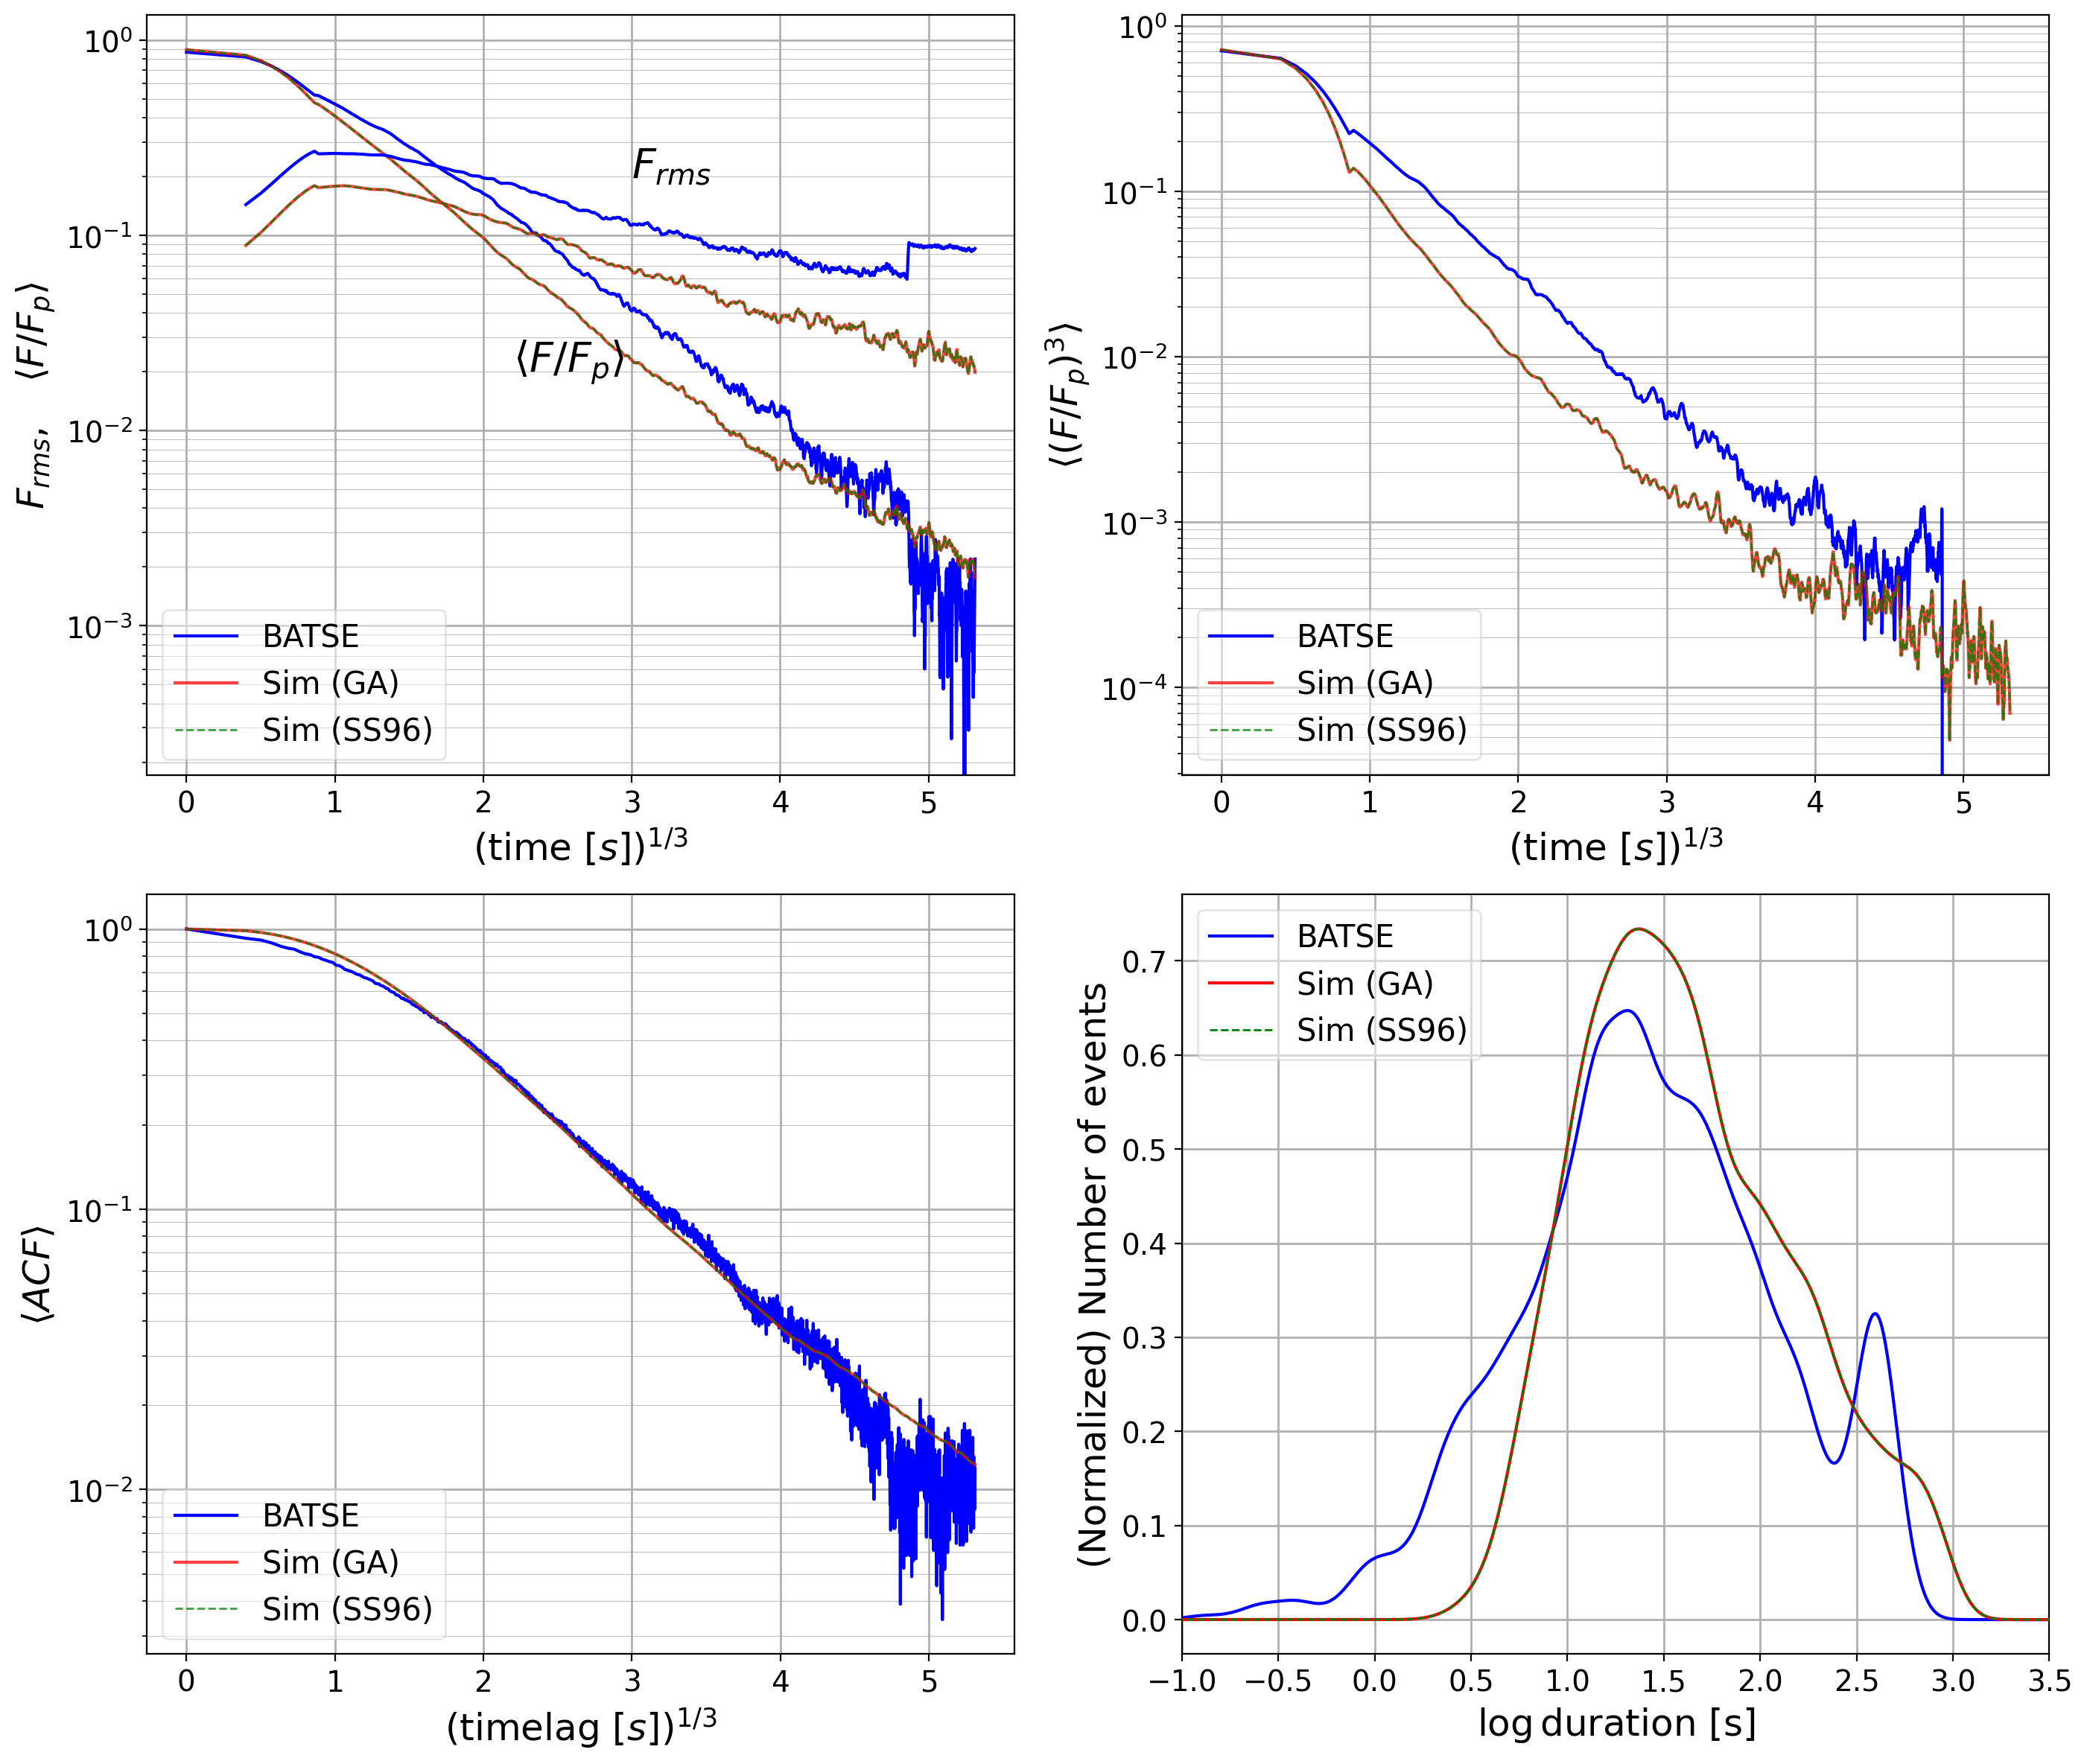

In [25]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot_2sim(instrument='batse',
               test_times=test_times_batse, 
               averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse, averaged_fluxes_sim_ga=averaged_fluxes_sim_batse_ga,
               averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse, averaged_fluxes_rms_sim_ga=averaged_fluxes_rms_sim_batse_ga,
               averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse, averaged_fluxes_cube_sim_ga=averaged_fluxes_cube_sim_batse_ga,
               steps=steps_batse, steps_sim=steps_sim_batse,    steps_sim_ga=steps_sim_batse_ga, bin_time=bin_time_batse, 
               acf=acf_batse,                                   acf_sim=acf_sim_batse, acf_sim_ga=acf_sim_batse_ga,
               duration=duration_batse,                         duration_sim=duration_sim_batse, duration_sim_ga=duration_sim_batse_ga,
               # mode
               log=True, hist=False, 
               # error bars
               err_bars=False, sigma=1,
               n_grb_real=len(grb_list_batse),                          n_grb_sim=len(grb_list_sim_batse),
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
               acf_rms=acf_rms_batse,                                   acf_rms_sim=acf_rms_sim_batse,
               save_fig=True, name_fig='4observables_L_tot_4_comparison.pdf')

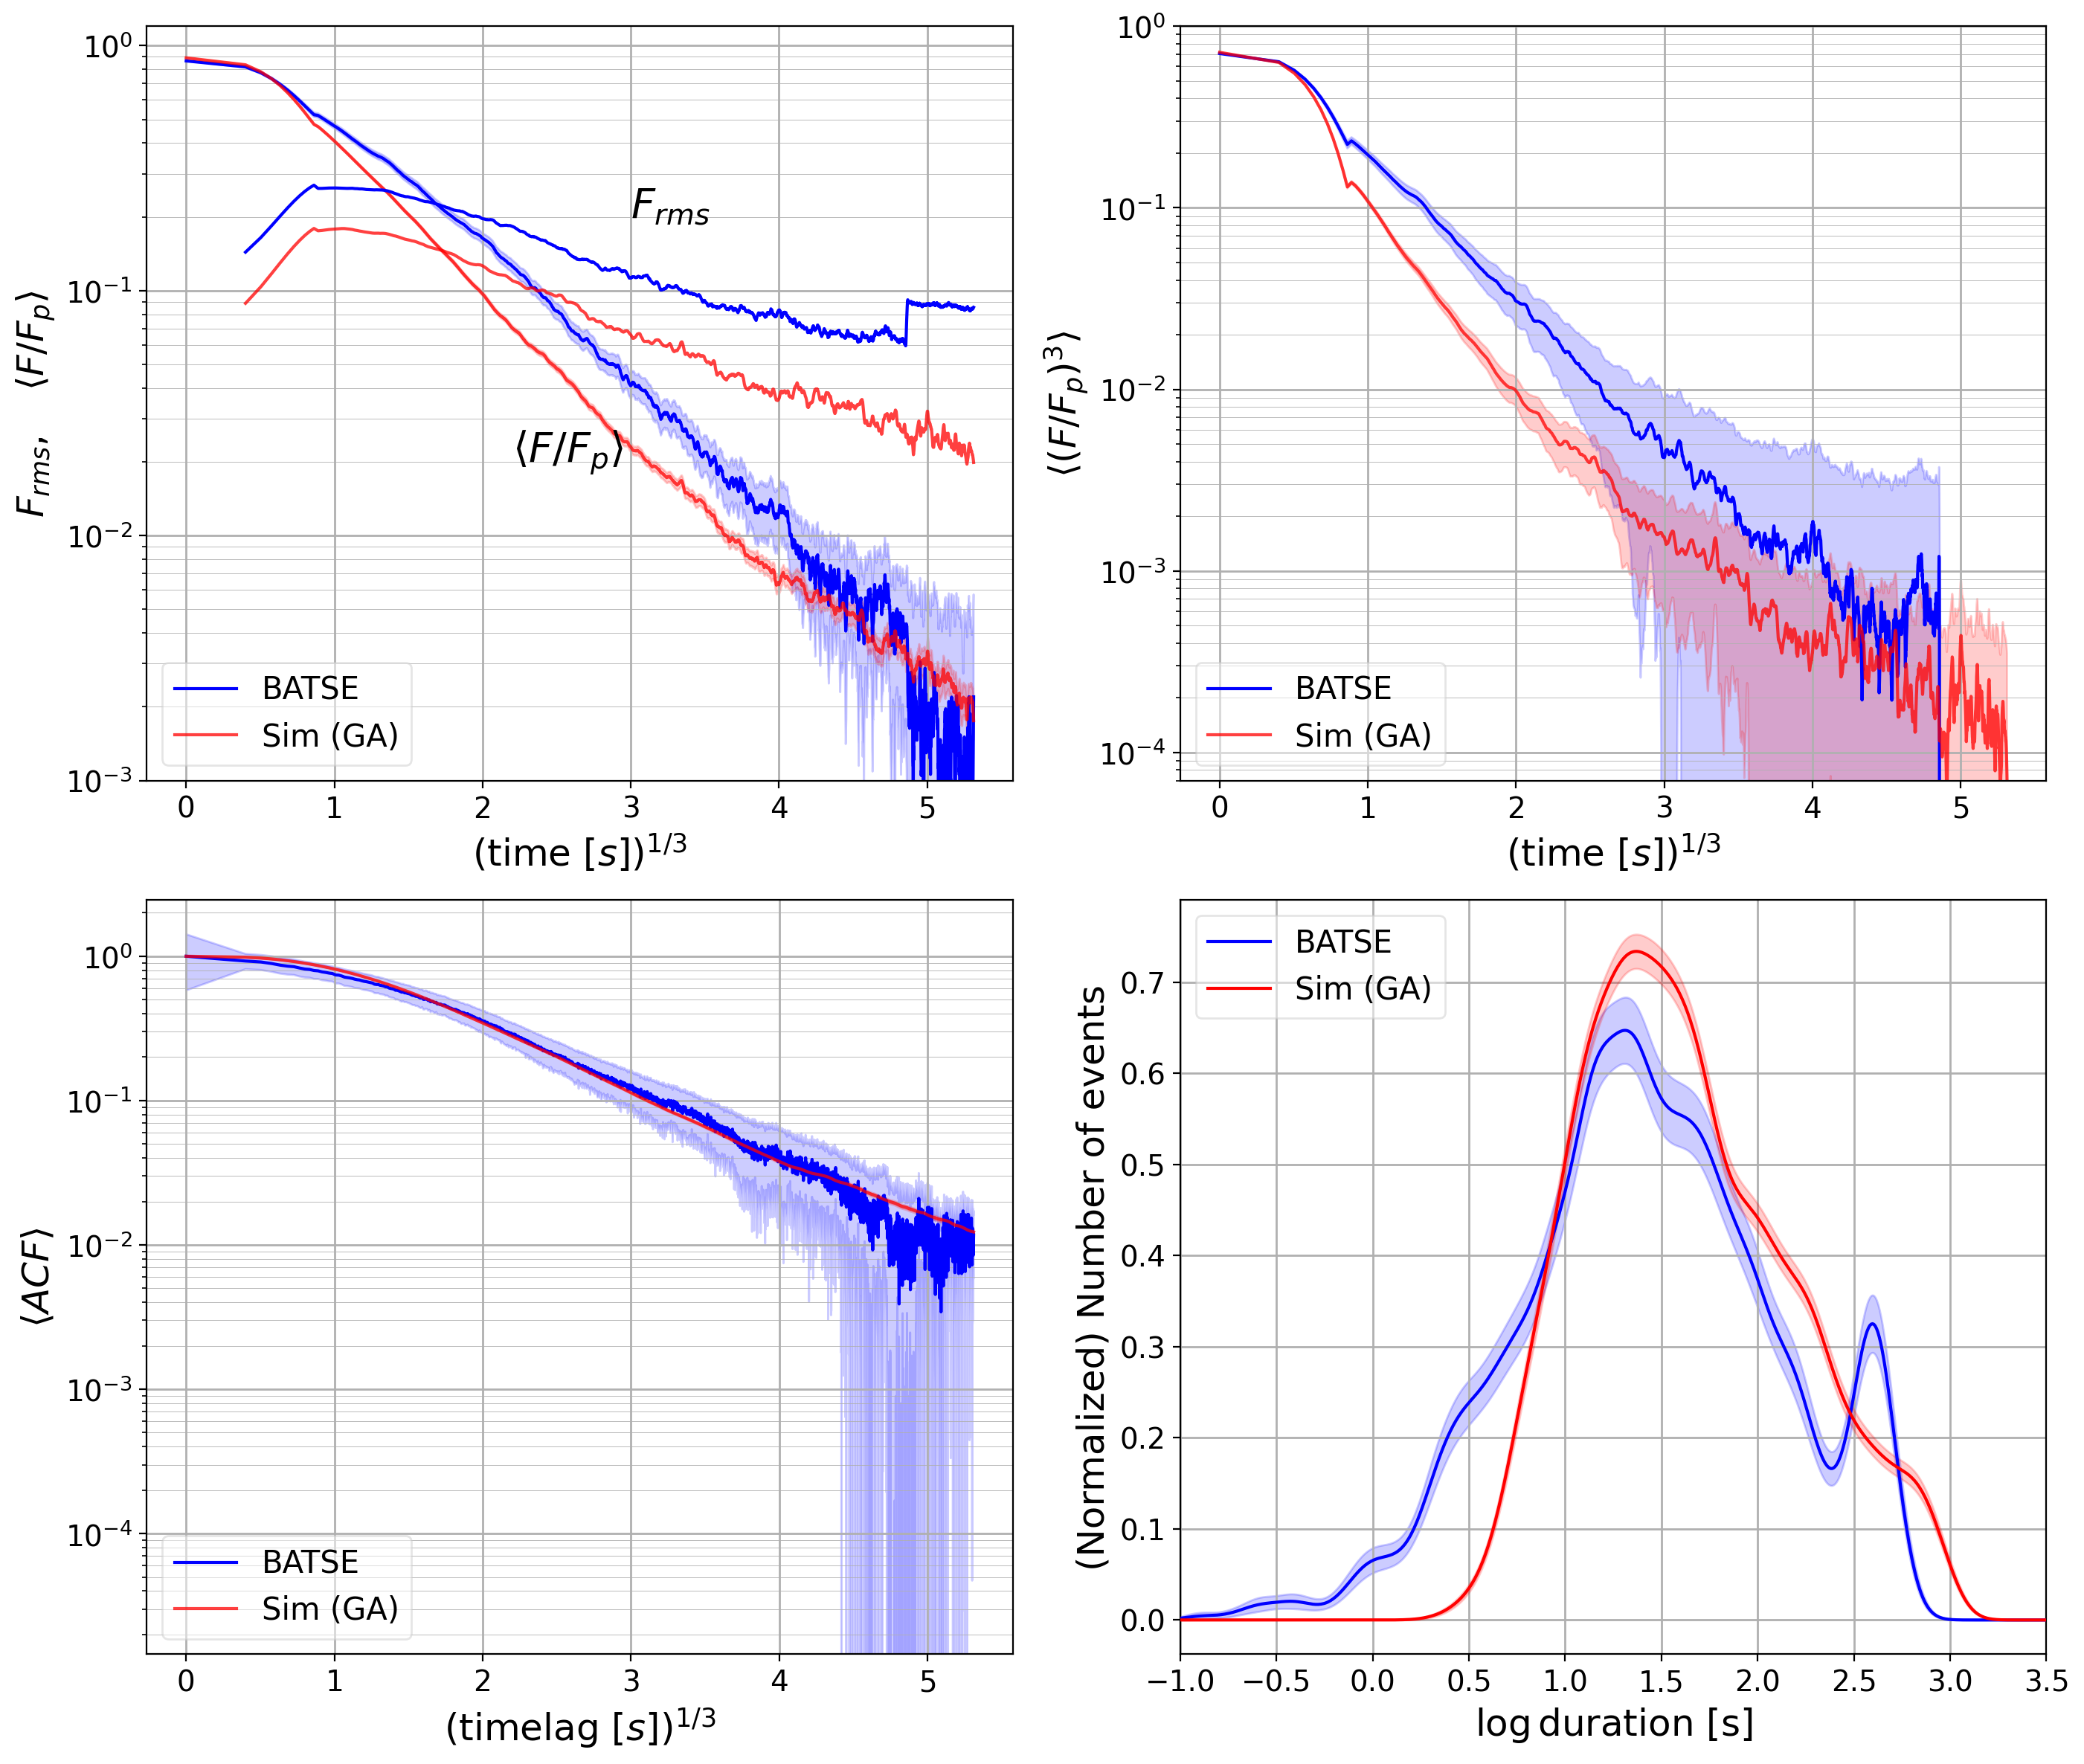

In [26]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse, bin_time=bin_time_batse, 
          acf=acf_batse,                                   acf_sim=acf_sim_batse,
          duration=duration_batse,                         duration_sim=duration_sim_batse,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=True, sigma=1,
          n_grb_real=len(grb_list_batse),                          n_grb_sim=len(grb_list_sim_batse),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
          acf_rms=acf_rms_batse,                                   acf_rms_sim=acf_rms_sim_batse,
          save_fig=True, name_fig='4observables_L_tot_4.pdf')

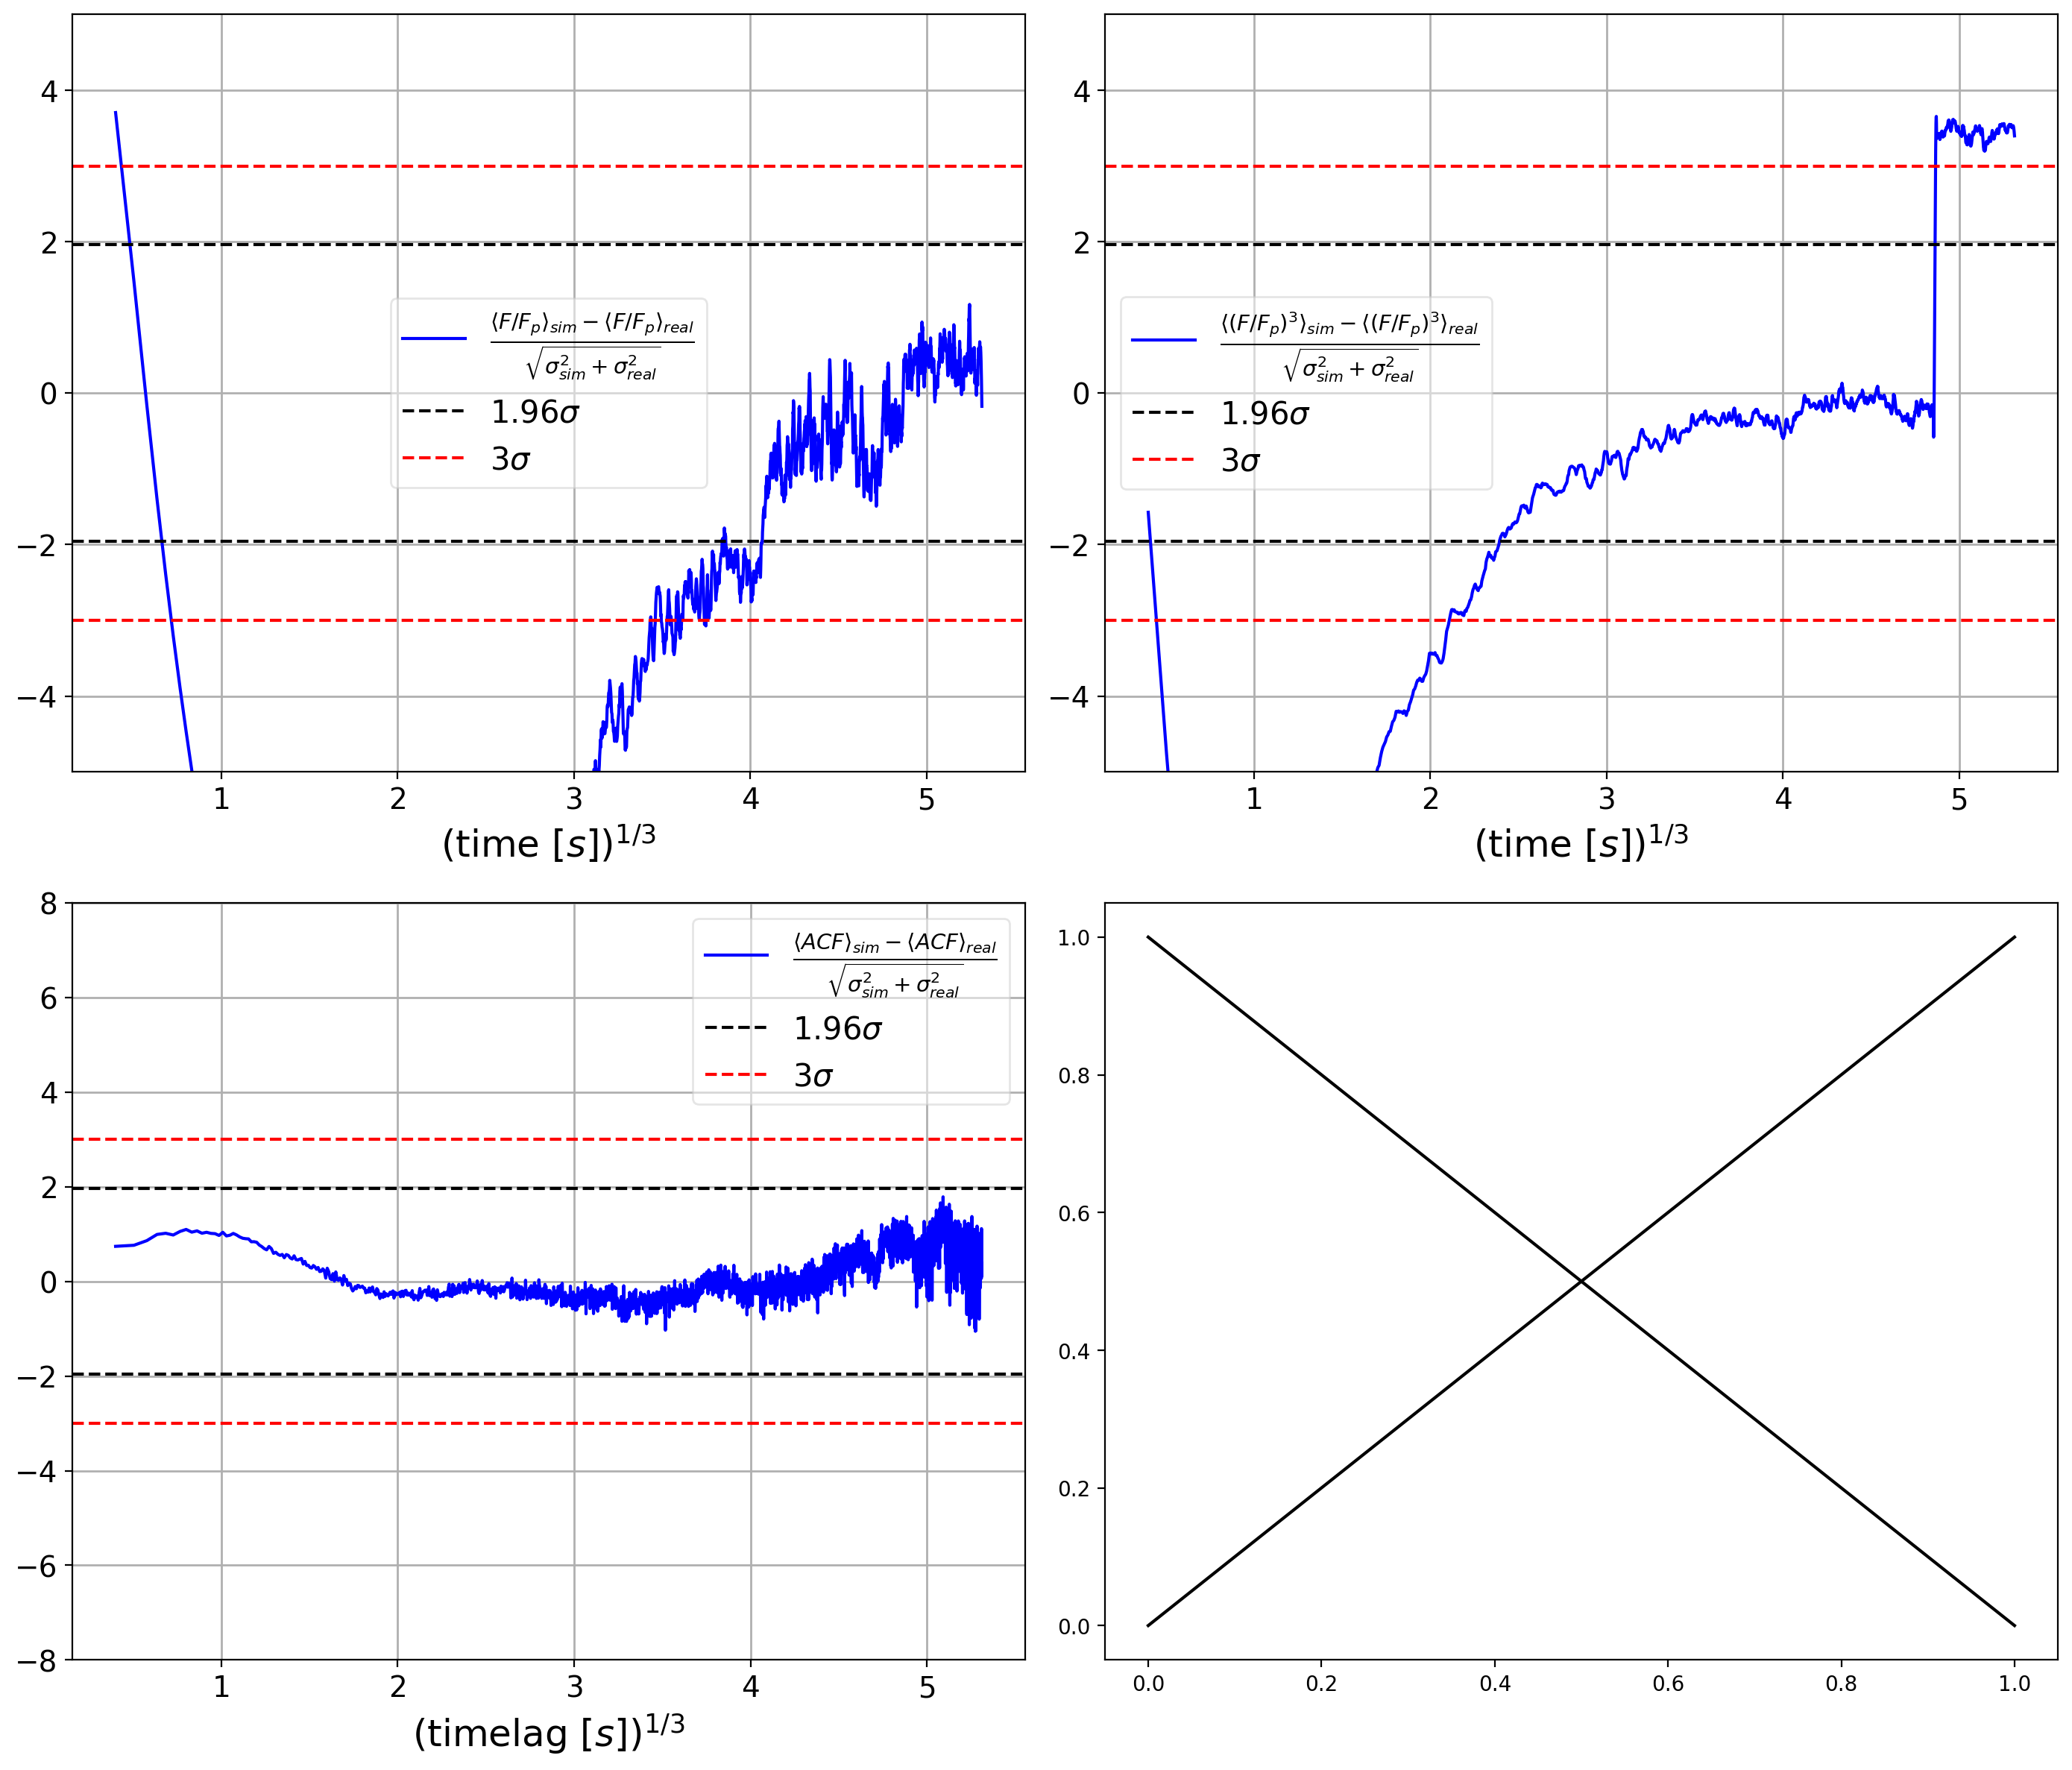

In [27]:
make_plot_errs(test_times=test_times_batse, 
               # plot 1
               averaged_fluxes=averaged_fluxes_batse,           
               averaged_fluxes_sim=averaged_fluxes_sim_batse,
               averaged_fluxes_rms=averaged_fluxes_rms_batse,   
               averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
               # plot 2
               averaged_fluxes_cube=averaged_fluxes_cube_batse, 
               averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, 
               averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
               # plot 3
               steps=steps_batse,  
               bin_time=bin_time_batse, 
               acf=acf_batse,
               acf_sim=acf_sim_batse,
               acf_rms=acf_rms_batse,
               acf_rms_sim=acf_rms_sim_batse,
               # plot 4
               duration=duration_batse, 
               duration_sim=duration_sim_batse,
               #
               n_grb_real=len(grb_list_batse),
               n_grb_sim=len(grb_list_sim_batse),
               save_fig=True, name_fig='4observables_LOSS_L_tot_4.pdf')

## Swift

In [ ]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='swift',
          test_times=test_times_swift, 
          averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
          averaged_fluxes_rms=averaged_fluxes_rms_swift,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
          averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
          steps=steps_swift, steps_sim=steps_sim_swift, bin_time=bin_time_swift, 
          acf=acf_swift,                                   acf_sim=acf_sim_swift,
          duration=duration_swift,                         duration_sim=duration_sim_swift,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=False, sigma=1,
          n_grb_real=len(grb_list_swift),                          n_grb_sim=len(grb_list_sim_swift),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_swift, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_swift,
          acf_rms=acf_rms_swift,                                   acf_rms_sim=acf_rms_sim_swift,
          save_fig=True, name_fig='metrics2.png')

In [ ]:
make_plot_errs(test_times=test_times_swift, 
               # plot 1
               averaged_fluxes=averaged_fluxes_swift,           
               averaged_fluxes_sim=averaged_fluxes_sim_swift,
               averaged_fluxes_rms=averaged_fluxes_rms_swift,   
               averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
               # plot 2
               averaged_fluxes_cube=averaged_fluxes_cube_swift, 
               averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_swift, 
               averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_swift,
               # plot 3
               steps=steps_swift,  
               bin_time=bin_time_swift, 
               acf=acf_swift,
               acf_sim=acf_sim_swift,
               acf_rms=acf_rms_swift,
               acf_rms_sim=acf_rms_sim_swift,
               # plot 4
               duration=duration_swift, 
               duration_sim=duration_sim_swift,
               #
               n_grb_real=len(grb_list_swift),
               n_grb_sim=len(grb_list_sim_swift))

## FERMI/GBM

In [ ]:
# FERMI/GBM ONLY
make_plot_one(instrument='fermi',
              test_times=test_times_fermi, 
              averaged_fluxes=averaged_fluxes_fermi,          
              averaged_fluxes_rms=averaged_fluxes_rms_fermi,  
              averaged_fluxes_cube=averaged_fluxes_cube_fermi,
              steps=steps_fermi, 
              bin_time=bin_time_fermi, 
              acf=acf_fermi,                                  
              duration=duration_fermi,                        
              # mode
              log=True, 
              hist=False, 
              # error bars
              err_bars=False, 
              sigma=1,
              n_grb_real=len(grb_list_fermi),                          
              averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_fermi, 
              acf_rms=acf_rms_fermi,                 
              save_fig=False)

In [ ]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='fermi',
          test_times=test_times_fermi, 
          averaged_fluxes=averaged_fluxes_fermi,           averaged_fluxes_sim=averaged_fluxes_sim_fermi,
          averaged_fluxes_rms=averaged_fluxes_rms_fermi,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_fermi,
          averaged_fluxes_cube=averaged_fluxes_cube_fermi, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_fermi,
          steps=steps_fermi, steps_sim=steps_sim_fermi,    bin_time=bin_time_fermi, 
          acf=acf_fermi,                                   acf_sim=acf_sim_fermi,
          duration=duration_fermi,                         duration_sim=duration_sim_fermi,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=False, sigma=1,
          n_grb_real=len(grb_list_fermi),                          n_grb_sim=len(grb_list_sim_fermi),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_fermi, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_fermi,
          acf_rms=acf_rms_fermi,                                   acf_rms_sim=acf_rms_sim_fermi,
          save_fig=True, name_fig='metrics_fermi.png')

In [ ]:
make_plot(instrument='fermi',
          test_times=test_times_fermi, 
          averaged_fluxes=averaged_fluxes_fermi,           averaged_fluxes_sim=averaged_fluxes_sim_fermi,
          averaged_fluxes_rms=averaged_fluxes_rms_fermi,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_fermi,
          averaged_fluxes_cube=averaged_fluxes_cube_fermi, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_fermi,
          steps=steps_fermi, steps_sim=steps_sim_fermi,    bin_time=bin_time_fermi, 
          acf=acf_fermi,                                   acf_sim=acf_sim_fermi,
          duration=duration_fermi,                         duration_sim=duration_sim_fermi,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=True, sigma=1,
          n_grb_real=len(grb_list_fermi),                          n_grb_sim=len(grb_list_sim_fermi),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_fermi, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_fermi,
          acf_rms=acf_rms_fermi,                                   acf_rms_sim=acf_rms_sim_fermi)

In [ ]:
# 7 PARAMETERS FROM THE PAPER
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim_batse,
          duration=duration_batse, duration_sim=duration_sim_batse)

In [ ]:
make_plot(instrument='swift',
          test_times=test_times_swift, 
          averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
          averaged_fluxes_rms=averaged_fluxes_rms_swift,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
          averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
          steps=steps_swift, steps_sim=steps_sim_swift, bin_time=bin_time_swift, acf=acf_swift, acf_sim=acf_sim_swift,
          duration=duration_swift, duration_sim=duration_sim_swift)

In [ ]:
make_plot(instrument='sax',
          test_times=test_times_sax_hr, 
          averaged_fluxes=averaged_fluxes_sax_hr,           averaged_fluxes_sim=averaged_fluxes_sim_sax_hr,
          averaged_fluxes_rms=averaged_fluxes_rms_sax_hr,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_sax_hr,
          averaged_fluxes_cube=averaged_fluxes_cube_sax_hr, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax_hr,
          steps=steps_sax_hr, steps_sim=steps_sim_sax_hr, bin_time=bin_time_sax_hr, acf=acf_sax_hr, acf_sim=acf_sim_sax_hr,
          duration=duration_sax_hr, duration_sim=duration_sim_sax_hr)

In [ ]:
make_plot(instrument='sax',
          test_times=test_times_sax_lr, 
          averaged_fluxes=averaged_fluxes_sax_lr,           averaged_fluxes_sim=averaged_fluxes_sim_sax_lr,
          averaged_fluxes_rms=averaged_fluxes_rms_sax_lr,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_sax_lr,
          averaged_fluxes_cube=averaged_fluxes_cube_sax_lr, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax_lr,
          steps=steps_sax_lr, steps_sim=steps_sim_sax_lr, bin_time=bin_time_sax_lr, acf=acf_sax_lr, acf_sim=acf_sim_sax_lr,
          duration=duration_sax_lr, duration_sim=duration_sim_sax_lr)

# DEBUG

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_batse = np.log10(duration_batse)
bwrange = np.linspace(0.01, 1.0, 50) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
# Fit the histogram data
grid.fit(x_batse[:, None]) 
h_opt = grid.best_params_['bandwidth']
print('optimal bandwisth: h_opt =', h_opt)

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_swift = np.log10(duration_swift)
bwrange = np.linspace(0.01, 1.0, 50) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
# Fit the histogram data
grid.fit(x_swift[:, None]) 
h_opt = grid.best_params_['bandwidth']
print('optimal bandwisth: h_opt =', h_opt)

In [ ]:
from scipy import stats

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_grid  = np.linspace(-4, 4, 1000)
y_plot  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot /= (len(x_batse))
#
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=3, fc='k', alpha=0.5)
ax.plot(x_grid, 10*y_plot.T, '-k', lw=0.5, alpha=0.4)
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='k', alpha=0.5)
ax.set_xlim(-0.5,3)

In [ ]:
from scipy import stats

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_grid  = np.linspace(-4, 4, 1000)
y_plot  = stats.norm.pdf(x_grid, x_swift[:, None], h_opt)
y_plot /= (len(x_swift))
#
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=3, fc='k', alpha=0.5)
ax.plot(x_grid, 10*y_plot.T, '-k', lw=0.5, alpha=0.4)
ax.plot(x_swift, 0*x_swift - 0.05, '|', c='k', alpha=0.5)
ax.set_xlim(-0.5,4)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_batse = np.log10(duration_batse)
x_sim   = np.log10(duration_sim_batse)
#
x_grid        = np.linspace(-2, 5, 1000)
y_plot_batse  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot_sim    = stats.norm.pdf(x_grid, x_sim[:, None],   h_opt)
y_plot_batse /= (len(x_batse))
y_plot_sim   /= (len(x_sim))
#
ax.fill(x_grid, y_plot_batse.sum(0), ec='b', lw=3, fc='b', alpha=0.5, label='BATSE')
ax.fill(x_grid, y_plot_sim.sum(0),   ec='r', lw=3, fc='r', alpha=0.5, label='sim')
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='b', alpha=0.5)
ax.plot(x_sim,   0*x_sim - 0.1,    '|', c='r', alpha=0.5)
ax.set_xlim(-0.7,3.2)
plt.legend()
plt.show()

### Estimate FERMI/GBM Background Count Rate

In [ ]:
### Load the FERMI/GBM GRBs

# load all data
grb_list_fermi = load_lc_fermi(path=fermi_path) 

# apply constraints
grb_list_fermi = apply_constraints(grb_list=grb_list_fermi, 
                                   bin_time=bin_time_fermi, 
                                   t90_threshold=t90_threshold, 
                                   t90_frac=t90_frac,
                                   sn_threshold=sn_threshold_fermi, 
                                   t_f=t_f)

In [ ]:
errs = []
for grb in grb_list_fermi:
    errs += list(grb.errs)
errs = np.array(errs)
errs = errs**2

errs_ = errs[errs<1000]
plt.hist(errs_, bins=100)
plt.axvline(np.mean(errs_), c='k')
plt.axvline(np.median(errs_), c='r')
plt.show()

median_bkg     = np.median(errs_) # counts/bin
bg_level_fermi = median_bkg/bin_time_fermi/instr_fermi['eff_area'] # background level FERMI/GBM [cnt/cm2/s]
bg_level_fermi 